In [1]:
import numpy as np
import pandas as pd
import tempfile
import tensorflow as tf
import matplotlib.pyplot as plt
import sklearn.metrics as skm
import yaml

import common

from fv3fit.train_microphysics import TrainConfig
import vcm

In [2]:
base = "zc-emu-monthly-normfix-m{init}-seed3-30d-v1"

In [3]:
url = common.get_group_url("zc-emu-monthly-normfix-m{init}-seed3-30d-v1-offline".format(init="01"))

No state saved for online runs.  Check offline instead.

In [4]:
gscond_model_path = "gs://vcm-ml-experiments/microphysics-emulation/2023-02-10/zc-train-gscond-normfix-seed3-v1"
classifier_path = "gs://vcm-ml-experiments/microphysics-emulation/2022-12-16/zc-train-gscond-classify-seed5-v2"
model = tf.keras.models.load_model(f"{gscond_model_path}/model.tf")
classifier = tf.keras.models.load_model(f"{classifier_path}/model.tf")

In [5]:
def load_model_config(path):
    with tempfile.TemporaryDirectory() as tmpdir:
        dst = f"{tmpdir}/config.yaml"
        !gsutil cp {path}/config.yaml {dst}
        with open(dst, "r") as f:
            d = yaml.safe_load(f)
            d.pop("seed")
            d.pop("loss")
        return TrainConfig.from_dict(d)

cfg = load_model_config(gscond_model_path)
cls_cfg = load_model_config(classifier_path)




Updates are available for some Google Cloud CLI components.  To install them,
please run:
  $ gcloud components update

Copying gs://vcm-ml-experiments/microphysics-emulation/2023-02-10/zc-train-gscond-normfix-seed3-v1/config.yaml...
/ [1 files][  2.9 KiB/  2.9 KiB]                                                
Operation completed over 1 objects/2.9 KiB.                                      
Copying gs://vcm-ml-experiments/microphysics-emulation/2022-12-16/zc-train-gscond-classify-seed5-v2/config.yaml...
/ [1 files][  2.4 KiB/  2.4 KiB]                                                
Operation completed over 1 objects/2.4 KiB.                                      


In [6]:
test = cfg.open_dataset(cfg.test_url, None, required_variables=cfg.model_variables | {"cloud_water_mixing_ratio_after_gscond"})
test = cfg.prepare_flat_data(test)

In [7]:
profiles = next(iter(test.shuffle(200_000).batch(150_000)))


In [8]:

transform = cfg.build_transform(profiles)

In [9]:
target = transform.backward(transform.forward(profiles))

In [10]:
predictions = model.predict(profiles, batch_size=512)

/home/andrep/miniconda3/envs/fv3net/lib/python3.8/site-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['specific_humidity_after_gscond', 'cloud_water_mixing_ratio_after_gscond'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


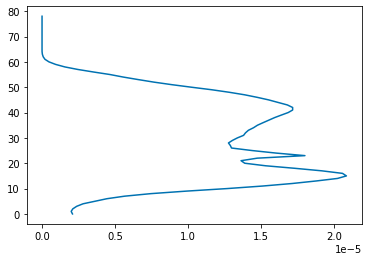

In [11]:
cin = profiles["cloud_water_mixing_ratio_input"]
cout = target["cloud_water_mixing_ratio_after_gscond"]
plt.plot(cout.numpy().mean(axis=0), range(79))

In [12]:
state_thresh = 1e-15
tend_thresh = 1e-15

tend = (cout - cin) / 900
some_cloud_out = tf.abs(cout) > state_thresh
negative_tend = tend < -tend_thresh


In [13]:
def plot_hexbin_dist(T, q, title, ax, q_condition=None, vmax=3e4, ylabel="dq [kg/kg/s]", xlabel="Temperature [K]", **kwargs):
    
    if q_condition=="neg":
        condition = q < 0
    elif q_condition=="pos":
        condition = q > 0
    else:
        condition = q != 0
            
    T = T[condition]
    q = q[condition]
    
    
    coll = ax.hexbin(abs(T), abs(np.array(q)), yscale="log", cmap="Greens", gridsize=150, bins="log", vmin=1, vmax=vmax, **kwargs)
    plt.colorbar(coll, ax=ax, label="count")
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title, size=14)

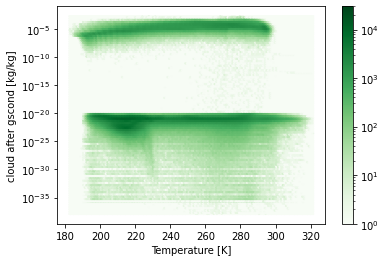

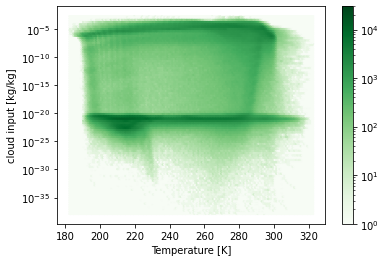

In [16]:
fig, ax = plt.subplots()
plot_hexbin_dist(target["air_temperature_input"], cout, "", ax, ylabel="cloud after gscond [kg/kg]")

fig, ax = plt.subplots()
plot_hexbin_dist(target["air_temperature_input"], cin, "", ax, ylabel="cloud input [kg/kg]")

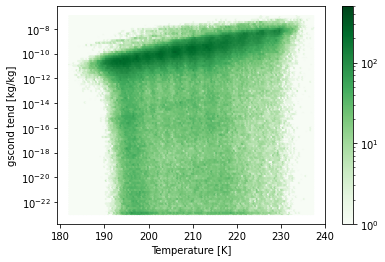

In [76]:
fig, ax = plt.subplots()
plot_hexbin_dist(target["air_temperature_input"][..., -29:-11].numpy().flatten(), tend[..., -29:-11].numpy().flatten(), "", ax, ylabel="gscond tend [kg/kg]", vmax=5e2)

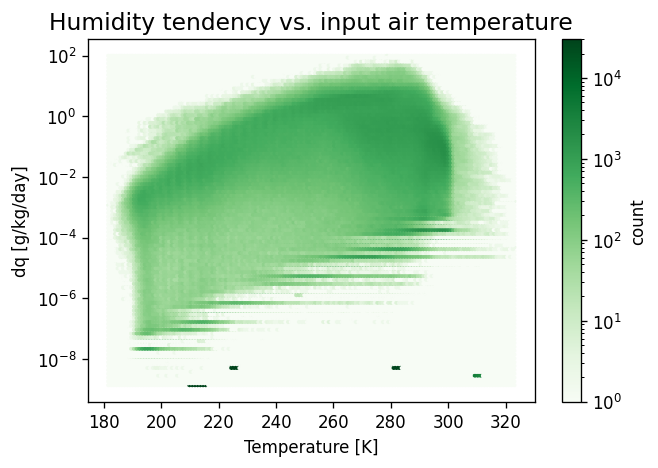

In [21]:
fig, ax = plt.subplots(dpi=120)
plot_hexbin_dist(target["air_temperature_input"], target["humidity_gscond_difference"]/900*(60**2 * 24)*1e3, "Humidity tendency vs. input air temperature", ax)
ax.set_ylabel("dq [g/kg/day]")
common.savefig("sup_dq_T_dependence")
plt.show()

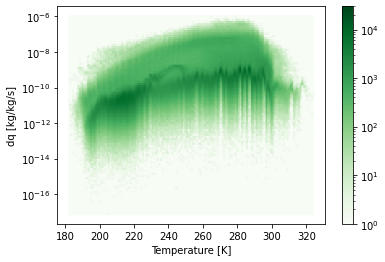

In [13]:
fig, ax = plt.subplots()
plot_hexbin_dist(target["air_temperature_input"], predictions["humidity_gscond_difference"]/900, "", ax)

In [14]:
POSITIVE_TENDENCY = "positive_tendency"
ZERO_TENDENCY = "zero_tendency"
ZERO_CLOUD = "zero_cloud"
NEGATIVE_TENDENCY = "negative_tendency"
NONTRIVIAL_TENDENCY = "nontrivial_tendency"

# this constant is reused elswhere so is effectively public api
CLASS_NAMES = {
    POSITIVE_TENDENCY,
    ZERO_TENDENCY,
    ZERO_CLOUD,
    NEGATIVE_TENDENCY,
}

def _get_classify_output(logit_classes, one_hot_axis=1):
    names = sorted(CLASS_NAMES)
    one_hot = logit_classes == np.max(logit_classes, axis=one_hot_axis, keepdims=True)
    d = {name: np.take(one_hot, i, one_hot_axis) for i, name in enumerate(names)}
    d["nontrivial_tendency"] = d[POSITIVE_TENDENCY] | d[NEGATIVE_TENDENCY]
    return d

def classify(cloud_in, cloud_out, timestep, math=tf.math):
    state_thresh = 1e-15
    tend_thresh = 1e-15

    tend = (cloud_out - cloud_in) / timestep
    some_cloud_out = math.abs(cloud_out) > state_thresh
    negative_tend = tend < -tend_thresh

    return {
        POSITIVE_TENDENCY: tend > tend_thresh,
        ZERO_TENDENCY: math.abs(tend) <= tend_thresh,
        ZERO_CLOUD: negative_tend & ~some_cloud_out,
        NEGATIVE_TENDENCY: negative_tend & some_cloud_out,
    }

In [15]:
cl_pred = classifier.predict(profiles, batch_size=512)


/home/andrep/miniconda3/envs/fv3net/lib/python3.8/site-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['specific_humidity_after_gscond', 'cloud_water_mixing_ratio_after_gscond'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


In [16]:

classified = _get_classify_output(cl_pred["gscond_classes"], one_hot_axis=-1)

In [17]:
target_classified = classify(cin, cout, 900)

In [18]:
def calc_precision(target, prediction, axis=None):
    targ_where_pred = np.where(prediction, target, 0)
    true_positive = np.logical_and(targ_where_pred, prediction).sum(axis=axis)
    false_positive = np.logical_xor(targ_where_pred, prediction).sum(axis=axis)
    return true_positive / (true_positive + false_positive)

def calc_recall(target, prediction, axis=None):
    targ_where_pred = np.where(prediction, target, 0)
    true_positive = np.logical_and(targ_where_pred, prediction).sum(axis=axis)
    not_pred = np.logical_not(prediction)
    targ_where_not_pred = np.where(not_pred, target, 0)
    false_negative = np.logical_and(targ_where_not_pred, not_pred).sum(axis=axis)
    return true_positive / (true_positive + false_negative)

def get_classifier_metrics(target_classes, pred_classes, levels=slice(-29, -11)):
    class_metrics = {}
    for k in target_classes.keys():
        pred_class = np.array(pred_classes[k][..., levels])
        targ_class = np.array(target_classes[k][..., levels])
        targ_perc = targ_class.sum() / targ_class.size
        pred_perc = pred_class.sum() / pred_class.size

        precision = calc_precision(targ_class, pred_class)
        recall = calc_recall(targ_class, pred_class)
        acc = skm.accuracy_score(targ_class.flatten(), pred_class.flatten())
        class_metrics[k] = np.array((targ_perc, pred_perc, precision, recall, acc))

    class_metrics = pd.DataFrame(
        class_metrics,
        index=["observed %", "predicted %", "precision", "recall", "accuracy"]
    ).transpose().round(2)

    return class_metrics

In [19]:
class_stats = get_classifier_metrics(target_classified, classified, levels=slice(None))
class_stats

observed %  predicted %  precision  recall  accuracy
positive_tendency        0.11         0.11       0.95    0.96      0.99
zero_tendency            0.63         0.65       0.95    0.99      0.96
zero_cloud               0.24         0.21       0.98    0.86      0.96
negative_tendency        0.02         0.02       0.90    0.90      0.99

In [20]:
print(class_stats.to_latex())

\begin{tabular}{lrrrrr}
\toprule
{} &  observed \% &  predicted \% &  precision &  recall &  accuracy \\
\midrule
positive\_tendency &        0.11 &         0.11 &       0.95 &    0.96 &      0.99 \\
zero\_tendency     &        0.63 &         0.65 &       0.95 &    0.99 &      0.96 \\
zero\_cloud        &        0.24 &         0.21 &       0.98 &    0.86 &      0.96 \\
negative\_tendency &        0.02 &         0.02 &       0.90 &    0.90 &      0.99 \\
\bottomrule
\end{tabular}



In [21]:
true_pos_true_neg = None
total = None
for k, v in target_classified.items():
    true_positive = np.logical_and(v, classified[k]).sum()
    true_negative = np.logical_and(np.logical_not(v), np.logical_not(classified[k])).sum()
    
    if true_pos_true_neg is None:
        true_pos_true_neg = true_positive + true_negative
        total = v.numpy().size
    else:
        true_pos_true_neg += true_positive + true_negative
        total += v.numpy().size

true_pos_true_neg / total

0.9757690717299579

In [22]:
class_fracs = {
    k: v.numpy().sum(axis=0) / v.numpy().shape[0]
    for k, v in target_classified.items()
}

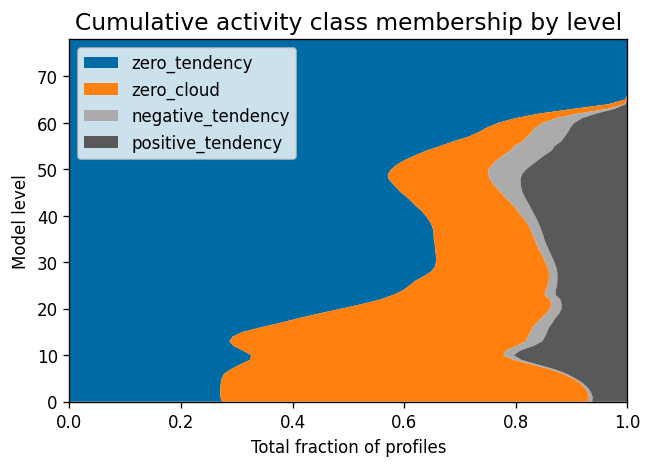

In [57]:
with plt.style.context("tableau-colorblind10"):
    key_order = [ZERO_TENDENCY, ZERO_CLOUD, NEGATIVE_TENDENCY, POSITIVE_TENDENCY]
    plt.figure(dpi=120)

    for i, k in enumerate(key_order):
        if i == 0:
            left = np.zeros_like(class_fracs[k])
            right = class_fracs[k]
        elif i == len(key_order):
            left = right
            right = np.ones_like(class_fracs[k])
        else:
            left = right
            right = left + class_fracs[k]

        plt.fill_betweenx(range(79), left, right, label=k)
    plt.legend(loc="upper left")
    plt.title("Cumulative activity class membership by level", size=14)
    plt.ylabel("Model level")
    plt.xlabel("Total fraction of profiles")
    plt.xlim(0, 1)
    plt.ylim(0, 78)
    common.savefig("sup_classifier_fractions")
    plt.show()

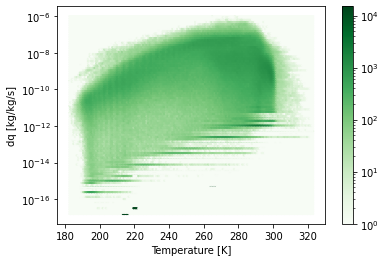

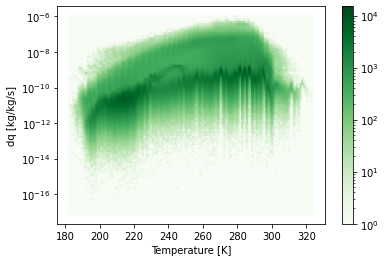

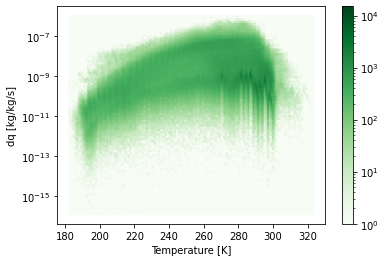

In [17]:
dc = -1 * predictions["humidity_gscond_difference"]/900
dc_masked = dc.copy()
dc_masked[classified["zero_tendency"]] = 0.0

fig, ax = plt.subplots()
plot_hexbin_dist(target["air_temperature_input"], target["humidity_gscond_difference"]/900, "", ax, vmax=1.5e4)

fig, ax = plt.subplots()
plot_hexbin_dist(target["air_temperature_input"], dc, "", ax, vmax=1.5e4)

fig, ax = plt.subplots()
plot_hexbin_dist(target["air_temperature_input"], dc_masked, "", ax, vmax=1.5e4)

## Arctic stratosphere only
compare target vs. what the predicted fractions are

In [23]:
arctic_test = cfg.open_dataset(cfg.train_url, nfiles=None, required_variables=set(cfg.model_variables | {"latitude", "cloud_water_mixing_ratio_after_gscond"}))
arctic_test = cfg.prepare_flat_data(arctic_test)

In [24]:
def limit_arc(d):
    arc_out = {}
    mask = np.squeeze(np.rad2deg(d["latitude"]) > 60)
    for k, v in d.items():
        arc_out[k] = v.numpy()[mask]

    return arc_out


combined_arc = {}
for b in iter(arctic_test.shuffle(150_000).batch(10_000)):
    limited = limit_arc(b)
    for k, v in limited.items():
        prev_b = combined_arc.get(k, [])
        combined = np.concatenate(prev_b + [v], axis=0)
        combined_arc[k] = [combined]
    
    if combined.shape[0] > 100_000:
        break

combined_arc = {k: v[0] for k, v in combined_arc.items()}


In [25]:
def limit_non_arc(d):
    out = {}
    lat_deg = np.squeeze(np.rad2deg(d["latitude"]))
    mask =  np.logical_and(lat_deg <= 60, lat_deg >= -60)
    for k, v in d.items():
        out[k] = v.numpy()[mask]

    return out

combined_non_arc = {}
for b in iter(arctic_test.shuffle(150_000).batch(10_000)):
    limited = limit_non_arc(b)
    for k, v in limited.items():
        prev_b = combined_non_arc.get(k, [])
        combined = np.concatenate(prev_b + [v], axis=0)
        combined_non_arc[k] = [combined]
    
    if combined.shape[0] > 100_000:
        break

combined_non_arc = {k: v[0] for k, v in combined_non_arc.items()}

In [26]:
def get_target_prediction(model, transform, profiles):
    predict = model.predict(profiles, batch_size=512)
    target = transform.backward(transform.forward(profiles))

    for k, v in profiles.items():
        if "_input" in k:
            target[k] = v

    return target, predict

In [27]:
arc_target, arc_gscond = get_target_prediction(model, transform, combined_arc)
_, arc_classified_ = get_target_prediction(classifier, transform, combined_arc)


/home/andrep/miniconda3/envs/fv3net/lib/python3.8/site-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['latitude', 'specific_humidity_after_gscond', 'cloud_water_mixing_ratio_after_gscond'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


In [28]:

arc_cl_target = classify(combined_arc["cloud_water_mixing_ratio_input"], combined_arc["cloud_water_mixing_ratio_after_gscond"], 900)
arc_classified = _get_classify_output(arc_classified_["gscond_classes"], one_hot_axis=-1)

In [29]:
tmp = {}
for k, v in arc_cl_target.items():
    if hasattr(v, "numpy"):
        tmp[k] = v.numpy()
    else:
        tmp[k] = v
arc_cl_target = tmp

<ipython-input-182-bf665484ce3b>:5: RuntimeWarning: invalid value encountered in true_divide
  return true_positive / (true_positive + false_positive)
<ipython-input-182-bf665484ce3b>:13: RuntimeWarning: invalid value encountered in true_divide
  return true_positive / (true_positive + false_negative)


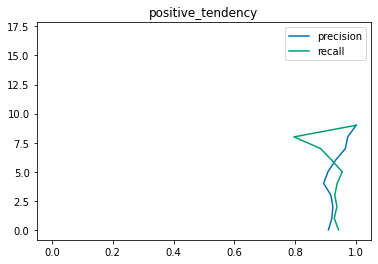

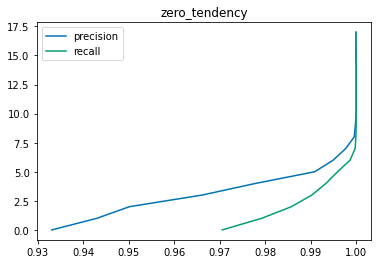

<ipython-input-182-bf665484ce3b>:5: RuntimeWarning: invalid value encountered in true_divide
  return true_positive / (true_positive + false_positive)
<ipython-input-182-bf665484ce3b>:13: RuntimeWarning: invalid value encountered in true_divide
  return true_positive / (true_positive + false_negative)


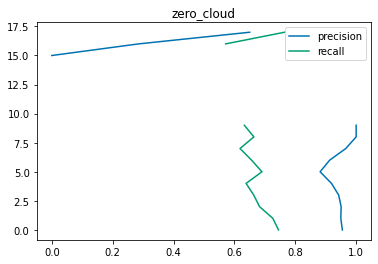

<ipython-input-182-bf665484ce3b>:5: RuntimeWarning: invalid value encountered in true_divide
  return true_positive / (true_positive + false_positive)
<ipython-input-182-bf665484ce3b>:13: RuntimeWarning: invalid value encountered in true_divide
  return true_positive / (true_positive + false_negative)


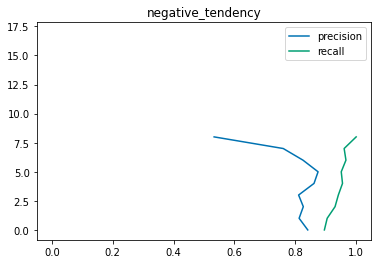

In [189]:
for k in arc_cl_target.keys():
    pred_class = arc_classified[k][..., -29:-11]
    targ_class = arc_cl_target[k][..., -29:-11]
    pr = calc_precision(targ_class, pred_class, axis=0)
    re = calc_recall(targ_class, pred_class, axis=0)
    plt.plot(pr, range(18), label="precision")
    plt.plot(re, range(18), label="recall")
    plt.title(k)
    plt.legend()
    plt.show()

In [186]:
get_classifier_metrics(arc_cl_target, arc_classified)

observed %  predicted %  precision  recall  accuracy
positive_tendency        0.03         0.03       0.91    0.94      1.00
zero_tendency            0.93         0.93       0.99    1.00      0.99
zero_cloud               0.03         0.03       0.94    0.70      0.99
negative_tendency        0.01         0.01       0.83    0.92      1.00

In [27]:
def get_pred_metrics(target, prediction, axis=None):
    diff = (target - prediction)
    mse = np.nanmean(diff**2, axis=axis)
    skill = 1 - (mse/(np.nanmean(target**2, axis=axis)))
    bias = np.mean(diff, axis=axis)
    return np.sqrt(mse), bias, skill


def plot_classifier_adjusted(target, prediction, pred_classes, strato=False, vmax=1.5e4):
    target_dq = target["humidity_gscond_difference"].numpy()/900
    pred_dq = prediction["humidity_gscond_difference"]/900
    T_in = target["air_temperature_input"]
    cloud_in = target["cloud_water_mixing_ratio_input"]
    zero_tend = pred_classes["zero_tendency"]
    zero_cloud = pred_classes["zero_cloud"]

    if strato:
        target_dq = target_dq[..., -29:-11]
        pred_dq = pred_dq[..., -29:-11]
        T_in = T_in[..., -29:-11]
        cloud_in = cloud_in[..., -29:-11]
        zero_tend = zero_tend[..., -29:-11]
        zero_cloud = zero_cloud[..., -29:-11]

    pred_dq_ztend = pred_dq.copy()
    pred_dq_ztend[zero_tend] = 0.0

    pred_dq_zcloud = pred_dq.copy()
    pred_dq_zcloud[zero_cloud] = cloud_in[zero_cloud]/900

    pred_dq_ztend_zcloud = pred_dq.copy()
    pred_dq_ztend_zcloud[zero_tend] = 0.0
    pred_dq_ztend_zcloud[zero_cloud] = cloud_in[zero_cloud]/900

    figsize = (6,4)
    dpi = 120
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    plot_hexbin_dist(T_in, target_dq, "Target dq distribution", ax, vmax=vmax)
    plt.xlim(180, 235)
    plt.ylim(1e-17, 1e-7)
    plt.show()

    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    plot_hexbin_dist(T_in, pred_dq, "Predicted dq distribution", ax, vmax=vmax)
    plt.xlim(180, 235)
    plt.ylim(1e-17, 1e-7)
    plt.show()
    print("rmse={:1.2e}, bias={:1.2e}, skill={:1.2f}".format(*get_pred_metrics(target_dq, pred_dq)))

    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    plot_hexbin_dist(T_in, pred_dq_ztend, "Predicted dq distribution (zero_tend)", ax, vmax=vmax)
    plt.xlim(180, 235)
    plt.ylim(1e-17, 1e-7)
    plt.show()
    print("rmse={:1.2e}, bias={:1.2e}, skill={:1.2f}".format(*get_pred_metrics(target_dq, pred_dq_ztend)))

    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    plot_hexbin_dist(T_in, pred_dq_zcloud, "Predicted dq distribution  (zero_cloud)", ax, vmax=vmax)
    plt.xlim(180, 235)
    plt.ylim(1e-17, 1e-7)
    plt.show()
    print("rmse={:1.2e}, bias={:1.2e}, skill={:1.2f}".format(*get_pred_metrics(target_dq, pred_dq_zcloud)))

    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    plot_hexbin_dist(T_in, pred_dq_ztend_zcloud, "Predicted dq distribution  (zero_tend, zero_cloud)", ax, vmax=vmax)
    plt.xlim(180, 235)
    plt.ylim(1e-17, 1e-7)
    plt.show()
    print("rmse={:1.2e}, bias={:1.2e}, skill={:1.2f}".format(*get_pred_metrics(target_dq, pred_dq_ztend_zcloud)))

    

In [27]:
arc_target["cloud_water_mixing_ratio_input"] = combined_arc["cloud_water_mixing_ratio_input"]

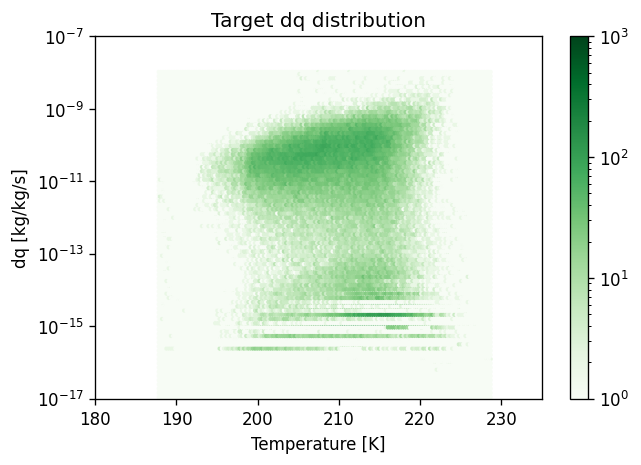

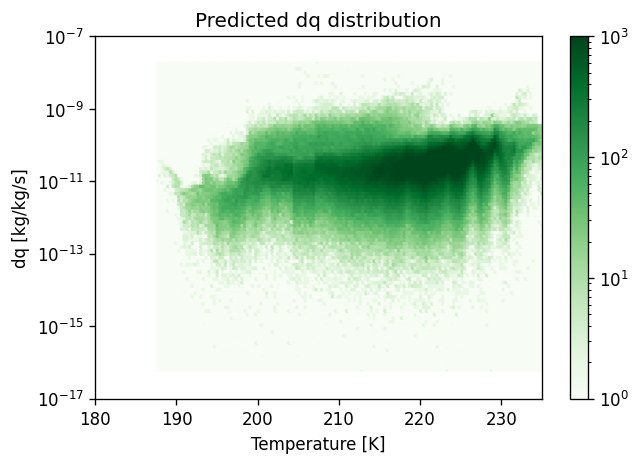

rmse=6.08e-11, bias=-4.10e-12, skill=0.19


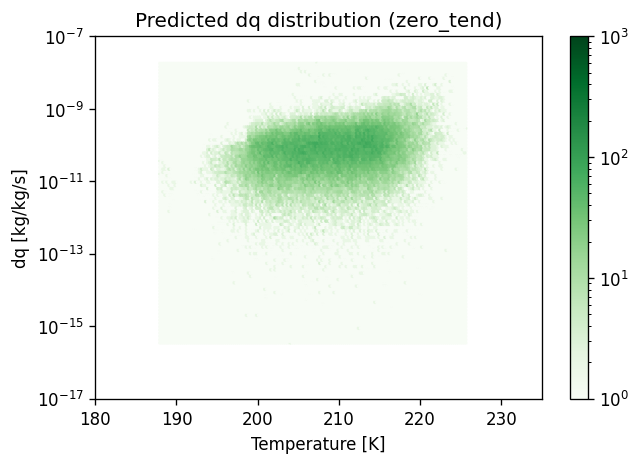

rmse=2.85e-11, bias=-6.37e-14, skill=0.82


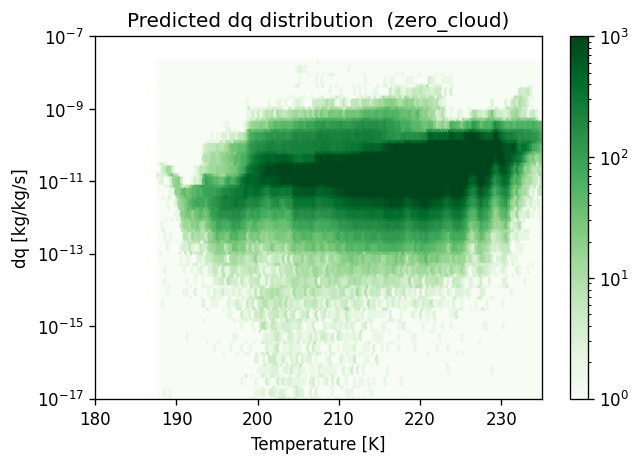

rmse=5.98e-11, bias=-3.94e-12, skill=0.22


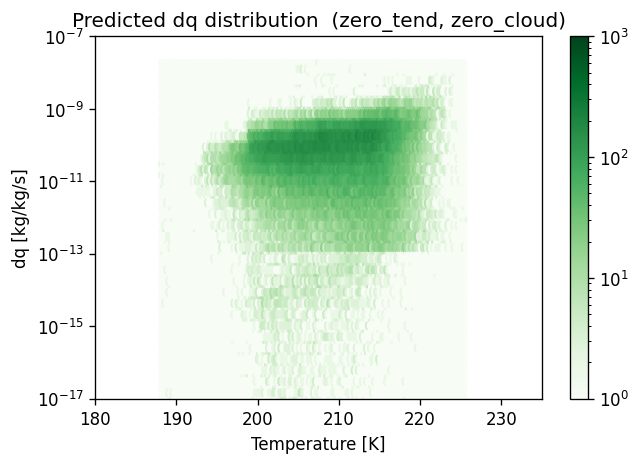

rmse=2.64e-11, bias=9.09e-14, skill=0.85


In [143]:
plot_classifier_adjusted(arc_target, arc_gscond, arc_classified, strato=True, vmax=1e3)

## What about for non-polar regions?

In [30]:
non_arc_target, non_arc_gscond = get_target_prediction(model, transform, combined_non_arc)
non_arc_cl_target, non_arc_classified = get_target_prediction(classifier, transform, combined_non_arc)
non_arc_cl_target = classify(combined_non_arc["cloud_water_mixing_ratio_input"], combined_non_arc["cloud_water_mixing_ratio_after_gscond"], 900)
non_arc_classified = _get_classify_output(non_arc_classified["gscond_classes"], one_hot_axis=-1)
tmp = {}
for k, v in non_arc_cl_target.items():
    if hasattr(v, "numpy"):
        tmp[k] = v.numpy()
    else:
        tmp[k] = v
non_arc_cl_target = tmp

In [27]:
get_classifier_metrics(non_arc_cl_target, non_arc_classified)

observed %  predicted %  precision  recall  accuracy
positive_tendency        0.09         0.09       0.95    0.98      0.99
zero_tendency            0.78         0.80       0.97    0.99      0.97
zero_cloud               0.09         0.07       0.94    0.74      0.97
negative_tendency        0.04         0.04       0.94    0.95      1.00

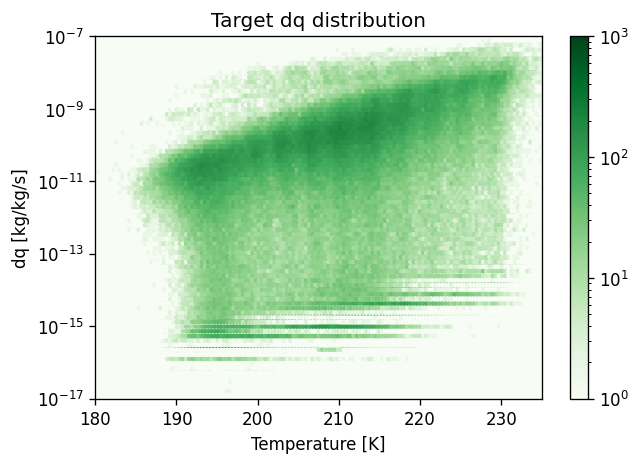

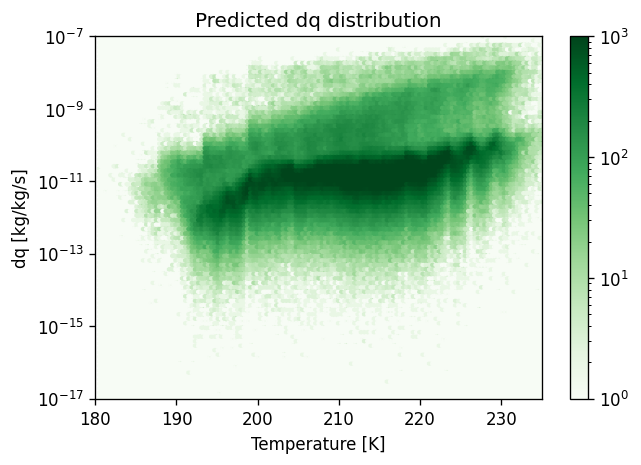

rmse=1.25e-10, bias=-9.84e-13, skill=0.99


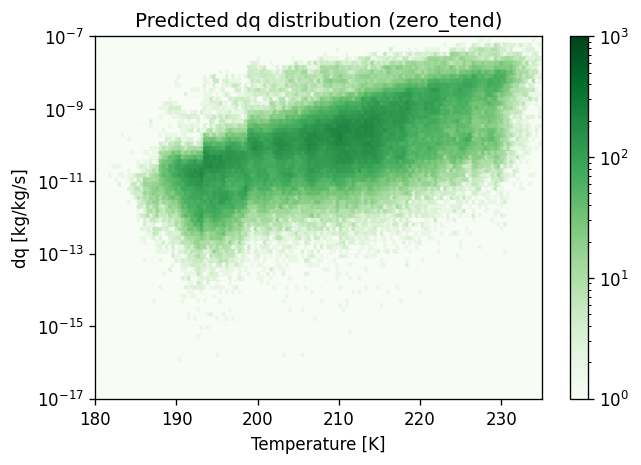

rmse=1.20e-10, bias=2.14e-12, skill=0.99


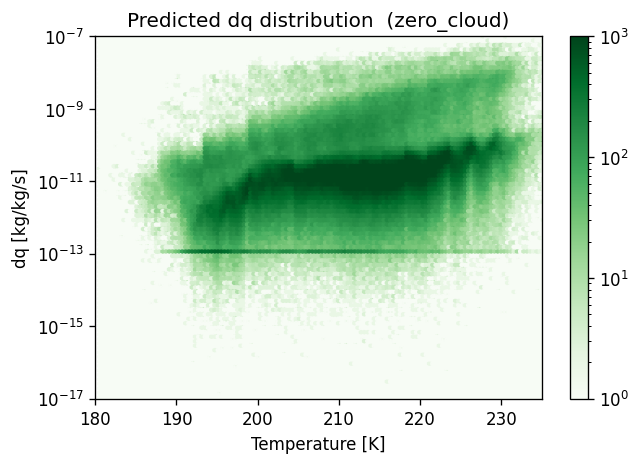

rmse=1.20e-10, bias=-8.38e-13, skill=0.99


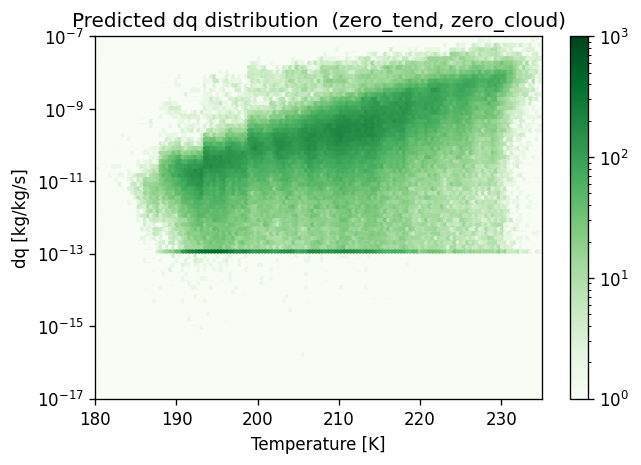

rmse=1.14e-10, bias=2.29e-12, skill=0.99


In [146]:
plot_classifier_adjusted(non_arc_target, non_arc_gscond, non_arc_classified, strato=True, vmax=1e3)

## Check the T-scaled distributions of raw gscond data

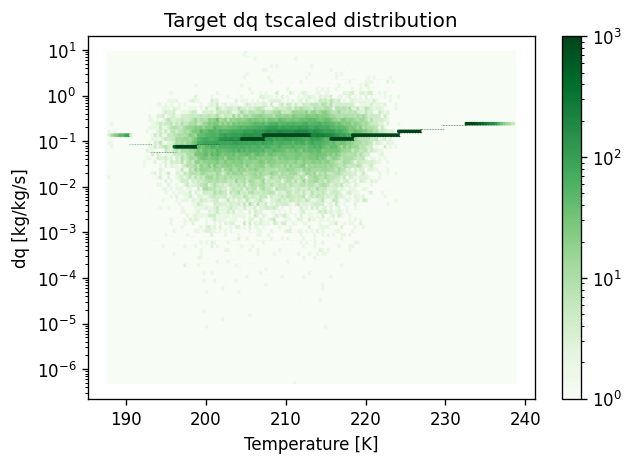

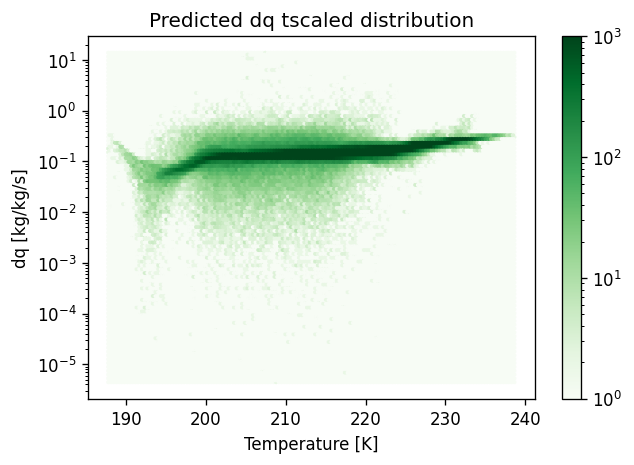

rmse=3.91e-02, bias=-2.42e-02, skill=0.93


In [147]:
fig, ax = plt.subplots(dpi=120)
T_in = combined_arc["air_temperature_input"][..., -29:-11]
dq_tscaled_targ = arc_target["humidity_gscond_difference_tscaled"][..., -29:-11]
dq_tscaled_pred = arc_gscond["humidity_gscond_difference_tscaled"][..., -29:-11]
plot_hexbin_dist(T_in, dq_tscaled_targ, "Target dq tscaled distribution", ax, vmax=1e3)
plt.show()

fig, ax = plt.subplots(dpi=120)
plot_hexbin_dist(T_in, dq_tscaled_pred, "Predicted dq tscaled distribution", ax, vmax=1e3)
plt.show()

print("rmse={:1.2e}, bias={:1.2e}, skill={:1.2f}".format(*get_pred_metrics(dq_tscaled_targ, dq_tscaled_pred)))

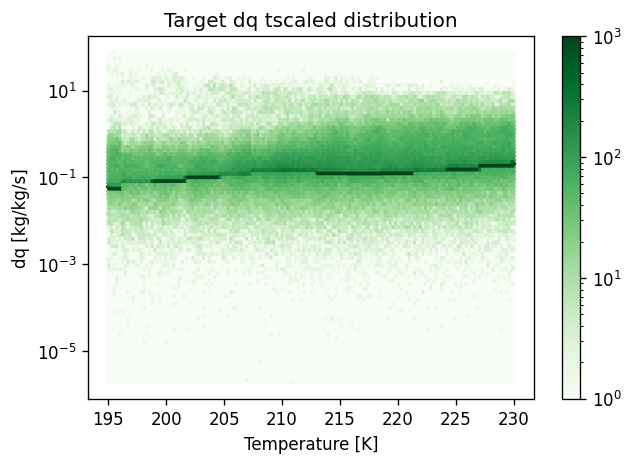

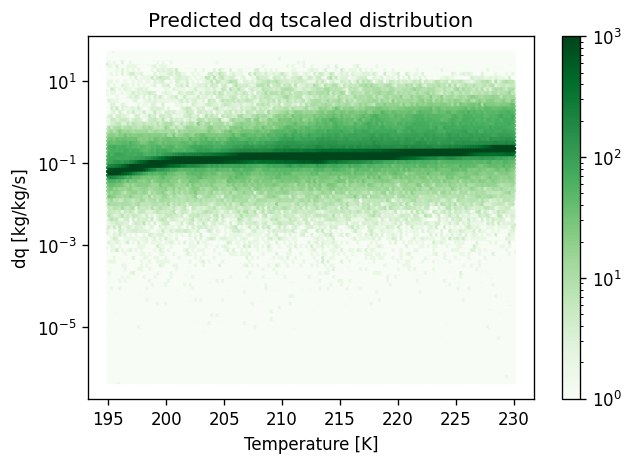

rmse=9.28e-02, bias=-1.92e-02, skill=0.96


In [148]:
fig, ax = plt.subplots(dpi=120)
T_in = combined_non_arc["air_temperature_input"]
T_mask = np.logical_and(T_in < 230, T_in > 195)
dq_tscaled_targ = non_arc_target["humidity_gscond_difference_tscaled"][T_mask]
dq_tscaled_pred = non_arc_gscond["humidity_gscond_difference_tscaled"][T_mask]
plot_hexbin_dist(T_in[T_mask], dq_tscaled_targ, "Target dq tscaled distribution", ax, vmax=1e3)
plt.show()

fig, ax = plt.subplots(dpi=120)
plot_hexbin_dist(T_in[T_mask], dq_tscaled_pred, "Predicted dq tscaled distribution", ax, vmax=1e3)
plt.show()

print("rmse={:1.2e}, bias={:1.2e}, skill={:1.2f}".format(*get_pred_metrics(dq_tscaled_targ, dq_tscaled_pred)))

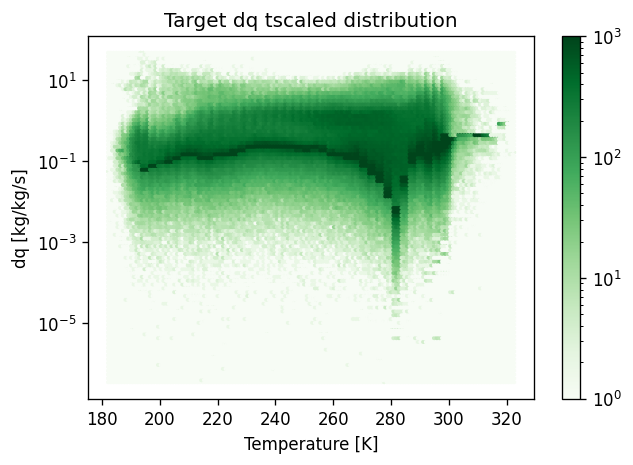

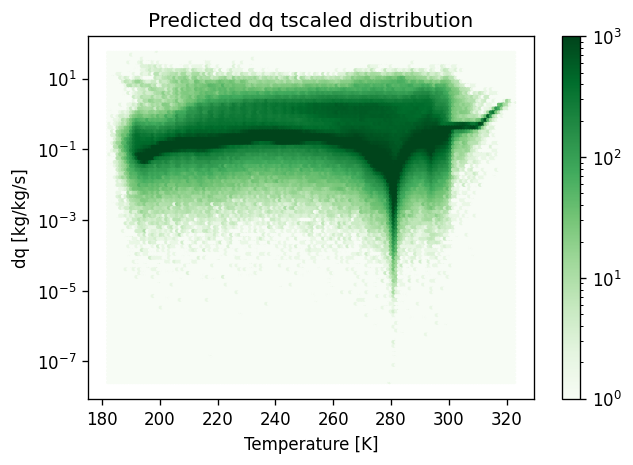

rmse=1.14e-01, bias=-1.33e-02, skill=0.96


In [153]:
fig, ax = plt.subplots(dpi=120)
T_in = profiles["air_temperature_input"]
dq_tscaled_targ = target["humidity_gscond_difference_tscaled"]
dq_tscaled_pred = predictions["humidity_gscond_difference_tscaled"]
plot_hexbin_dist(T_in, dq_tscaled_targ, "Target dq tscaled distribution", ax, vmax=1e3)
plt.show()



fig, ax = plt.subplots(dpi=120)
plot_hexbin_dist(T_in, dq_tscaled_pred, "Predicted dq tscaled distribution", ax, vmax=1e3)
plt.show()

print("rmse={:1.2e}, bias={:1.2e}, skill={:1.2f}".format(*get_pred_metrics(dq_tscaled_targ, dq_tscaled_pred)))

In [155]:
0.114**2

0.012996

## Zero cloud miss locations target vs pred dq

In [212]:
def plot_hist_comparison(data1, label1, data2, label2):

    bins = np.logspace(-15, -7, 50)
    plt.figure(dpi=120)
    plt.hist(
        abs(data1.flatten()),
        bins=bins,
        log=True,
        histtype="step",
        label=label1
    )
    plt.hist(
        abs(data2.flatten()),
        bins=bins,
        log=True,
        histtype="step",
        label=label2
    )
    plt.gca().set_xscale("log")
    plt.legend()

In [213]:
dq_targ = arc_target["humidity_gscond_difference"][..., -29:-11]/900
dq_pred = arc_gscond["humidity_gscond_difference"][..., -29:-11]/900
neg_targ_idx = dq_targ > 0

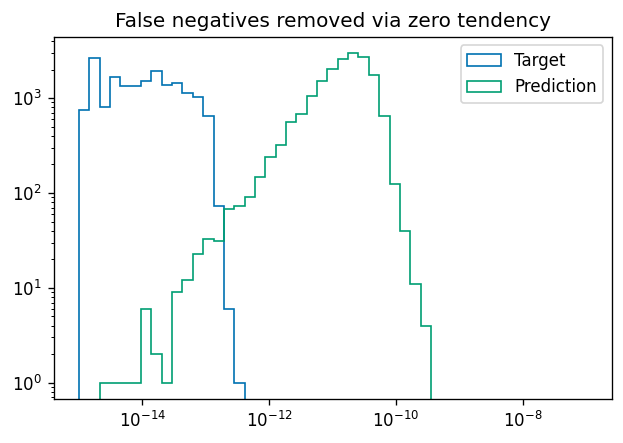

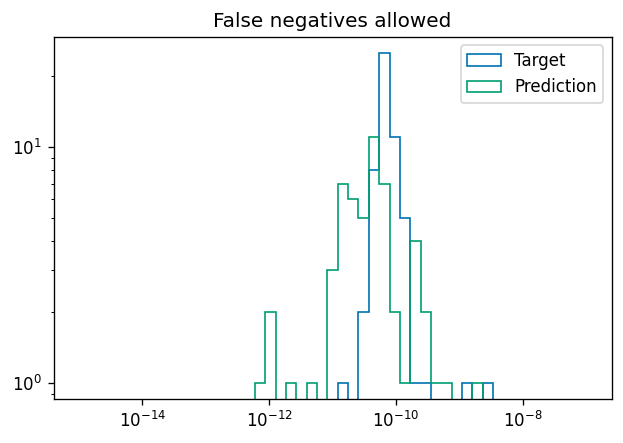

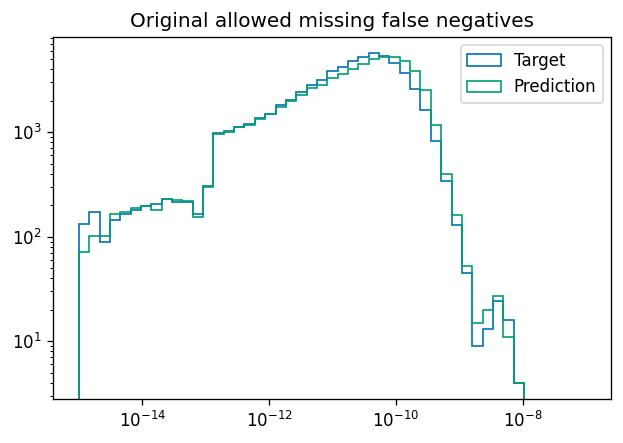

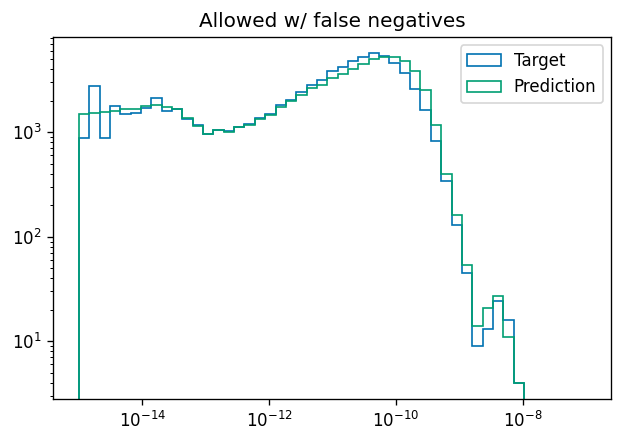

In [217]:
cloud_in = combined_arc["cloud_water_mixing_ratio_input"][..., -29:-11][neg_targ_idx]
nontrivial = arc_classified["nontrivial_tendency"][..., -29:-11][neg_targ_idx]
zero_cloud = arc_classified["zero_cloud"][..., -29:-11][neg_targ_idx]
zero_tend = arc_classified["zero_tendency"][..., -29:-11][neg_targ_idx]
zero_cloud_target = arc_cl_target["zero_cloud"][..., -29:-11][neg_targ_idx]

false_negatives =  np.logical_and(zero_cloud_target == True, zero_cloud == False)
removed =  zero_tend & false_negatives
allowed_fn = nontrivial & false_negatives
allowed =  zero_cloud | nontrivial
perfect_precision = allowed | false_negatives

adjusted = dq_pred[neg_targ_idx].copy()
adjusted[zero_tend] = 0.0
adjusted[zero_cloud] = cloud_in[zero_cloud]/900
adjusted_perfect_precision = dq_pred[neg_targ_idx].copy()
adjusted_perfect_precision[zero_tend] = 0.0
adjusted_perfect_precision[zero_cloud | false_negatives] = cloud_in[zero_cloud | false_negatives]/900

plot_hist_comparison(dq_targ[neg_targ_idx][removed].numpy(), "Target", dq_pred[neg_targ_idx][removed], "Prediction")
plt.title("False negatives removed via zero tendency")
plt.show()

plot_hist_comparison(dq_targ[neg_targ_idx][allowed_fn].numpy(), "Target", dq_pred[neg_targ_idx][allowed_fn], "Prediction")
plt.title("False negatives allowed")
plt.show()

plot_hist_comparison(dq_targ[neg_targ_idx][allowed].numpy(), "Target", adjusted[allowed], "Prediction")
plt.title("Original allowed missing false negatives")
plt.show()

plot_hist_comparison(dq_targ[neg_targ_idx][perfect_precision].numpy(), "Target", adjusted_perfect_precision[perfect_precision], "Prediction")
plt.title("Allowed w/ false negatives")
plt.show()


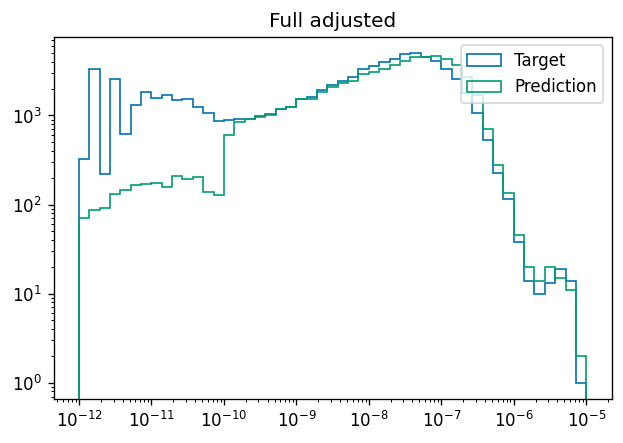

In [208]:

plot_hist_comparison(dq_targ[neg_targ_idx].numpy(), "Target", adjusted, "Prediction")
plt.title("Full adjusted")
plt.show()


# false negative + zero tendency = distribution components supressed
# false negative + nontrivial = distribution combonents allowed
# zero cloud + nontrivial = predicted evaporation
# zero cloud + nontrivial + false negative

In [216]:
2.29e-12 * 86400

1.9785600000000002e-07

## Check RMS vs RMSE of Arctic vs. Non-arctic in Arctic temperature range

In [31]:
import xarray as xr

In [32]:
print(arc_target["air_temperature_input"][:, -29:-11].min())
print(arc_target["air_temperature_input"][:, -29:-11].max())

187.79614
238.62454


In [33]:
T_in = non_arc_target["air_temperature_input"]
T_in_arc = arc_target["air_temperature_input"]

In [34]:
dims = {
    T_in.shape: ["sample", "z"], 
    tuple([T_in.shape[0], 1]): ["sample"],
    T_in_arc.shape: ["sample", "z"],
    tuple([T_in_arc.shape[0], 1]): ["sample"],
}

def get_ds(data, dims):
    ds = xr.Dataset()
    for k, v in data.items():
        ds[k] = xr.DataArray(np.squeeze(v), dims=dims[tuple(v.shape)], name=k)
    return ds

non_arc_target_ds = get_ds(non_arc_target, dims)
arc_target_ds = get_ds(arc_target, dims)
non_arc_gscond_ds = get_ds(non_arc_gscond, dims)
arc_gscond_ds = get_ds(arc_gscond, dims)


In [35]:
print(f"max{T_in_arc[:, -29:-11].max()}")
print(f"min{T_in_arc[:, -29:-11].min()}")

max238.62454223632812
min187.796142578125


In [36]:
arc_gscond_ds["air_temperature_input"] = arc_target_ds["air_temperature_input"]


In [37]:
np.rad2deg(arc_target_ds.latitude).min()

<xarray.DataArray 'latitude' ()>
array(60.087875, dtype=float32)

In [ ]:
# Temperature > 185K and < 240K
bins = np.linspace(190, 285, 12)
arc_rmse = np.sqrt(((arc_gscond_ds - arc_target_ds)**2).groupby_bins(arc_target_ds.air_temperature_input, bins).mean())
arc_rms = np.sqrt((arc_target_ds**2).groupby_bins(arc_target_ds.air_temperature_input, bins).mean())

T_mask = np.logical_and((non_arc_target_ds.air_temperature_input > 185), (non_arc_target_ds.air_temperature_input < 285))
non_arc_rmse = np.sqrt(((non_arc_gscond_ds.where(T_mask) - non_arc_target_ds.where(T_mask))**2).groupby_bins(non_arc_target_ds.air_temperature_input.where(T_mask), bins).mean())
# use same temperature bins as in arctic
# compare the rms, rmse in two regions using the binned data

In [ ]:

non_arc_rms = np.sqrt((non_arc_target_ds.where(T_mask)**2).groupby_bins(non_arc_target_ds.where(T_mask).air_temperature_input, bins).mean())

In [ ]:
arc_counts = arc_target_ds.groupby_bins(arc_target_ds.air_temperature_input, bins).count()
non_arc_counts = non_arc_target_ds.where(T_mask).groupby_bins(non_arc_target_ds.where(T_mask).air_temperature_input, bins).count()

In [61]:
midpoints = np.array([v.mid for v in arc_counts["air_temperature_input_bins"].values])
ac = arc_counts.humidity_gscond_difference_tscaled.values
nac = non_arc_counts.humidity_gscond_difference_tscaled.values

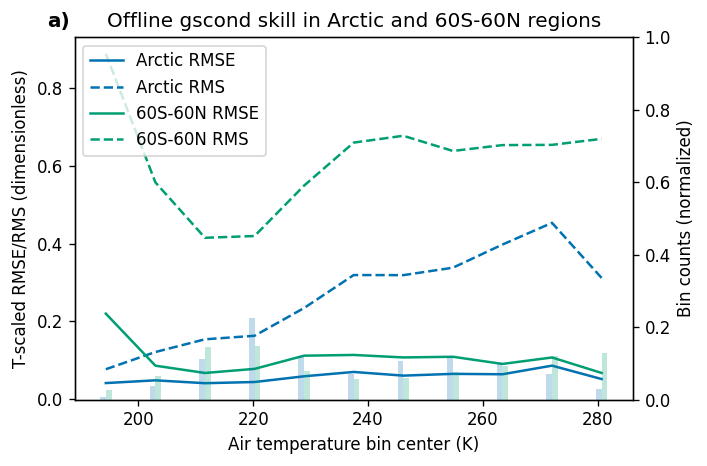

In [62]:
# plot a comparison of the two regions RMS and RMSE
fig,ax = plt.subplots(dpi=120)
ax2 = ax.twinx()

ax2.bar(midpoints-0.5, ac/ac.sum(), width=1, alpha=0.25, label="Arctic counts")
ax2.bar(midpoints+0.5, nac/nac.sum(), width=1, alpha=0.25, label="60S-60N counts")
ax2.set_ylim(0, 1)
# (tscale_counts/tscale_counts.sum(axis=0)).plot(ax=ax2, kind="bar", alpha=0.5, legend=False)

line, = arc_rmse["humidity_gscond_difference_tscaled"].plot(x="air_temperature_input_bins", label="Arctic RMSE", ax=ax)
arc_rms["humidity_gscond_difference_tscaled"].plot(x="air_temperature_input_bins", label="Arctic RMS", linestyle="--", color=line.get_color(), ax=ax)

line, = non_arc_rmse["humidity_gscond_difference_tscaled"].plot(x="air_temperature_input_bins", label="60S-60N RMSE", ax=ax)
non_arc_rms["humidity_gscond_difference_tscaled"].plot(x="air_temperature_input_bins", label="60S-60N RMS", linestyle="--", color=line.get_color(), ax=ax)
ax.legend()
ax.set_xlabel("Air temperature bin center (K)")
ax.set_ylabel("T-scaled RMSE/RMS (dimensionless)")
ax2.set_ylabel("Bin counts (normalized)")
ax.set_title("Offline gscond skill in Arctic and 60S-60N regions")
ax.text(-0.05, 1.07, "a)", transform=ax.transAxes, fontsize=12, fontweight="bold", va="top", ha="left")

plt.show()

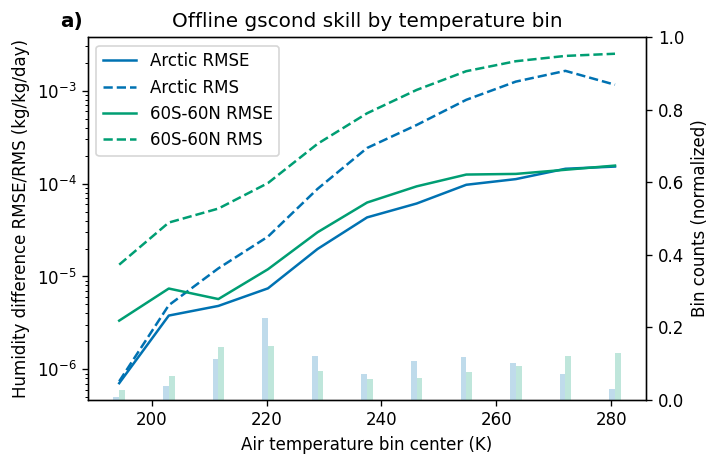

In [74]:
fig,ax = plt.subplots(dpi=120)
ax2 = ax.twinx()

ax2.bar(midpoints-0.5, ac/ac.sum(), width=1, alpha=0.25, label="Arctic counts")
ax2.bar(midpoints+0.5, nac/nac.sum(), width=1, alpha=0.25, label="60S-60N counts")
ax2.set_ylim(0, 1)

scale_factor = 60**2 * 24 / 900  # seconds per day
line, = (arc_rmse["humidity_gscond_difference"]*scale_factor).plot(x="air_temperature_input_bins", label="Arctic RMSE", ax=ax)
(arc_rms["humidity_gscond_difference"]*scale_factor).plot(x="air_temperature_input_bins", label="Arctic RMS", linestyle="--", color=line.get_color(), ax=ax)


line, = (non_arc_rmse["humidity_gscond_difference"]*scale_factor).plot(x="air_temperature_input_bins", label="60S-60N RMSE", ax=ax)
(non_arc_rms["humidity_gscond_difference"]*scale_factor).plot(x="air_temperature_input_bins", label="60S-60N RMS", linestyle="--", color=line.get_color(), ax=ax)
ax.legend()
ax.set_yscale("log")

ax.set_xlabel("Air temperature bin center (K)")
ax.set_ylabel("Humidity difference RMSE/RMS (kg/kg/day)")
ax2.set_ylabel("Bin counts (normalized)")
ax.set_title("Offline gscond skill by temperature bin")
ax.text(-0.05, 1.07, "a)", transform=ax.transAxes, fontsize=12, fontweight="bold", va="top", ha="left")
plt.show()

In [64]:

arc_bias = (arc_gscond_ds - arc_target_ds).groupby_bins(arc_target_ds.air_temperature_input, bins).mean()
non_arc_bias = (non_arc_gscond_ds.where(T_mask) - non_arc_target_ds.where(T_mask)).groupby_bins(non_arc_target_ds.air_temperature_input.where(T_mask), bins).mean()

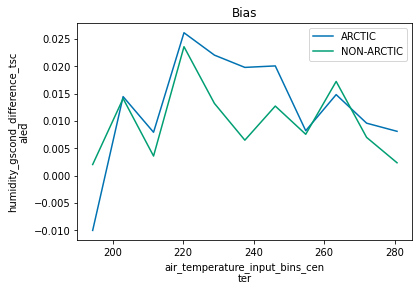

In [65]:
arc_bias["humidity_gscond_difference_tscaled"].plot(x="air_temperature_input_bins", label="ARCTIC")
non_arc_bias["humidity_gscond_difference_tscaled"].plot(x="air_temperature_input_bins", label="NON-ARCTIC")
plt.title("Bias")
plt.legend()
plt.show()

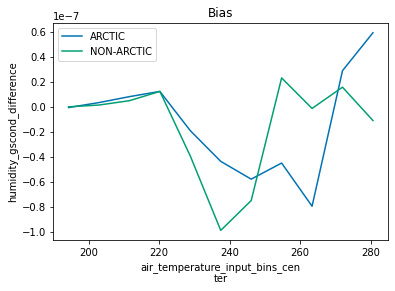

In [66]:
arc_bias["humidity_gscond_difference"].plot(x="air_temperature_input_bins", label="ARCTIC")
non_arc_bias["humidity_gscond_difference"].plot(x="air_temperature_input_bins", label="NON-ARCTIC")
plt.title("Bias")
plt.legend()
plt.show()

In [36]:
arc_lev_rmse = np.sqrt(((arc_gscond_ds.isel(z=slice(-29, -11)) - arc_target_ds.isel(z=slice(-29, -11)))**2).mean("sample"))
arc_lev_rms = np.sqrt((arc_target_ds.isel(z=slice(-29, -11))**2).mean("sample"))
arc_lev_bias = (arc_gscond_ds.isel(z=slice(-29, -11)) - arc_target_ds.isel(z=slice(-29, -11))).mean("sample")
non_arc_lev_rmse = np.sqrt(((non_arc_gscond_ds.isel(z=slice(-29, -11)) - non_arc_target_ds.isel(z=slice(-29, -11)))**2).mean("sample"))
non_arc_lev_rms = np.sqrt((non_arc_target_ds.isel(z=slice(-29, -11))**2).mean("sample"))
non_arc_lev_bias = (non_arc_gscond_ds.isel(z=slice(-29, -11)) - non_arc_target_ds.isel(z=slice(-29, -11))).mean("sample")

In [37]:
from matplotlib import ticker

ref_pressure = np.round(profiles["air_pressure"].numpy().mean(axis=0)[-29:-11]/100, 0).astype(int)

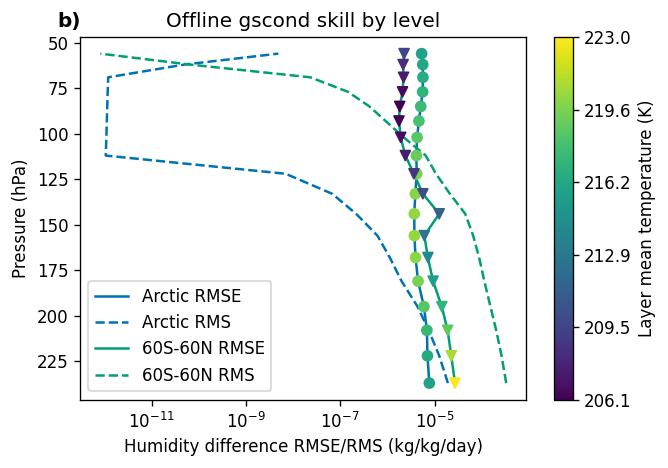

In [38]:
avg_arc_temp = arc_target_ds.air_temperature_input.mean("sample").isel(z=slice(-29, -11)).values
avg_non_arc_temp = non_arc_target_ds.air_temperature_input.mean("sample").isel(z=slice(-29, -11)).values

max_temp = max(avg_arc_temp.max(), avg_non_arc_temp.max())
min_temp = min(avg_arc_temp.min(), avg_non_arc_temp.min())

norm_arc_temp = (avg_arc_temp - min_temp) / (max_temp - min_temp)
norm_non_arc_temp = (avg_non_arc_temp - min_temp) / (max_temp - min_temp)
color_bar_labels = np.linspace(min_temp, max_temp, 6, endpoint=True)
color_bar_labels = [f"{label:3.1f}" for label in color_bar_labels]

scale_factor = 60**2 * 24 / 900  # seconds per day
colormap = plt.cm.viridis
plt.figure(dpi=120)
line, = plt.plot(arc_lev_rmse["humidity_gscond_difference"]*scale_factor, ref_pressure, label="Arctic RMSE")
plt.scatter(arc_lev_rmse["humidity_gscond_difference"]*scale_factor, ref_pressure, c=colormap(norm_arc_temp), zorder=10)
plt.plot(arc_lev_rms["humidity_gscond_difference"]*scale_factor, ref_pressure, label="Arctic RMS", color=line.get_color(), linestyle="--")
cbar = plt.colorbar(label="Layer mean temperature (K)")
cbar.ax.set_yticklabels(color_bar_labels)


line, = plt.plot(non_arc_lev_rmse["humidity_gscond_difference"]*scale_factor, ref_pressure, label="60S-60N RMSE")
plt.scatter(non_arc_lev_rmse["humidity_gscond_difference"]*scale_factor, ref_pressure, c=colormap(norm_non_arc_temp), marker="v", zorder=10)
plt.plot(non_arc_lev_rms["humidity_gscond_difference"]*scale_factor, ref_pressure, label="60S-60N RMS", color=line.get_color(), linestyle="--")

plt.title("Offline gscond skill by level")
plt.ylabel("")
plt.legend()
plt.xscale("log")

ax = plt.gca().invert_yaxis()

plt.ylabel("Pressure (hPa)")
plt.xlabel("Humidity difference RMSE/RMS (kg/kg/day)")

plt.text(-0.05, 1.07, "b)", transform=plt.gca().transAxes, fontsize=12, fontweight="bold", va="top", ha="left")
plt.show()

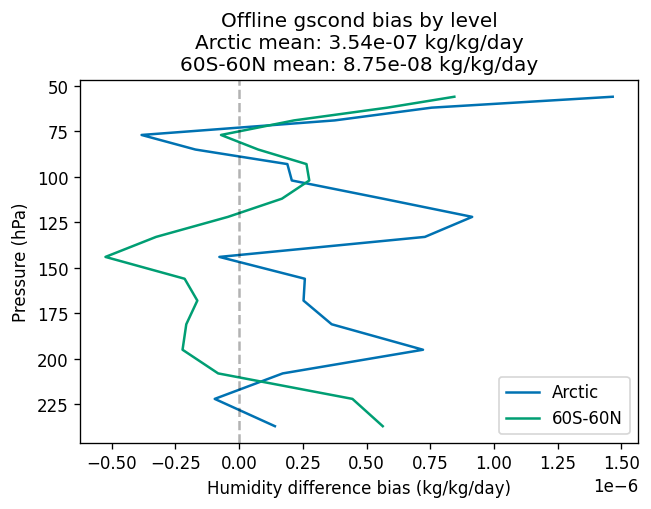

In [138]:
plt.figure(dpi=120)
plt.plot((arc_lev_bias["humidity_gscond_difference"] * scale_factor), ref_pressure, label="Arctic")
plt.plot((non_arc_lev_bias["humidity_gscond_difference"] * scale_factor), ref_pressure, label="60S-60N")
avg_arc_bias = (arc_lev_bias["humidity_gscond_difference"] * scale_factor).mean()
avg_non_arc_bias = (non_arc_lev_bias["humidity_gscond_difference"] * scale_factor).mean()
plt.axvline(0, color="k", linestyle="--", alpha=0.3)
plt.title(
    "Offline gscond bias by level\n"
    f"Arctic mean: {avg_arc_bias.values:1.2e} kg/kg/day\n"
    f"60S-60N mean: {avg_non_arc_bias.values:1.2e} kg/kg/day"
)
plt.xlabel("Humidity difference bias (kg/kg/day)")
plt.legend()
plt.gca().invert_yaxis()
plt.ylabel("Pressure (hPa)")
plt.show()

<xarray.DataArray 'humidity_gscond_difference' ()>
array(3.5430702e-07, dtype=float32)

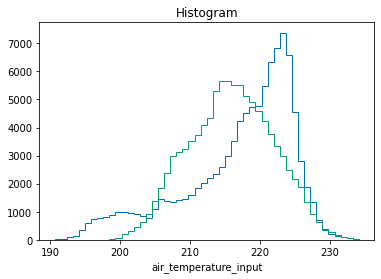

In [88]:
res = arc_target_ds.air_temperature_input.isel(z=-15).plot.hist(bins=50, histtype="step")
arc_target_ds.air_temperature_input.isel(z=-29).plot.hist(bins=res[1], histtype="step")
plt.show()


In [45]:
z1, non_arc_T = xr.broadcast(arc_target_ds.z, non_arc_target_ds.air_temperature_input)
z2, arc_T = xr.broadcast(arc_target_ds.z, arc_target_ds.air_temperature_input)

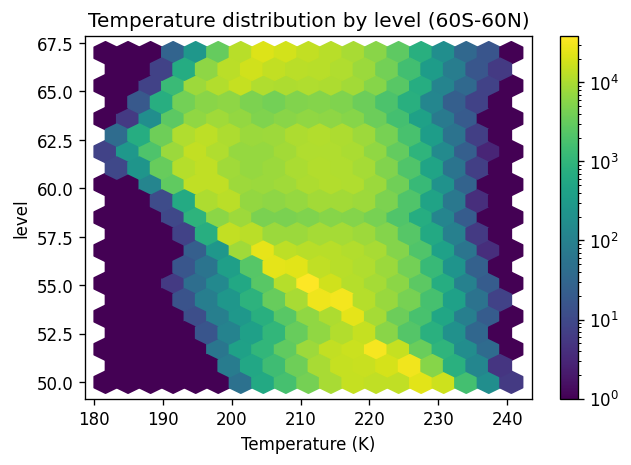

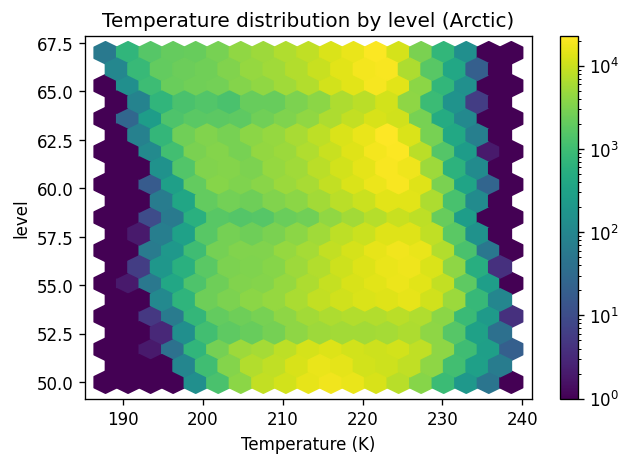

In [46]:
plt.figure(dpi=120)
plt.hexbin(non_arc_T.isel(z=slice(-29, -11)).values.flatten(), z1.isel(z=slice(-29, -11)).values.flatten(),  bins="log", cmap="viridis", gridsize=18)
plt.colorbar()
plt.title("Temperature distribution by level (60S-60N)")
plt.ylabel("level")
plt.xlabel("Temperature (K)")
plt.show()

plt.figure(dpi=120)
plt.hexbin(arc_T.isel(z=slice(-29, -11)).values.flatten(), z2.isel(z=slice(-29, -11)).values.flatten(),  bins="log", cmap="viridis", gridsize=18)
plt.colorbar()
plt.title("Temperature distribution by level (Arctic)")
plt.ylabel("level")
plt.xlabel("Temperature (K)")
plt.show()

In [105]:
bins = np.linspace(190, 285, 12)
bins

array([190.        , 198.63636364, 207.27272727, 215.90909091,
       224.54545455, 233.18181818, 241.81818182, 250.45454545,
       259.09090909, 267.72727273, 276.36363636, 285.        ])

In [114]:
tm.isel(z=slice(-29,-11)).sum("sample")

<xarray.DataArray 'air_temperature_input' (z: 18)>
array([49304, 44945, 42923, 43401, 44319, 45572, 46330, 47262, 48280,
       49884, 51590, 53874, 56409, 58679, 59776, 59943, 59448, 58449])
Dimensions without coordinates: z

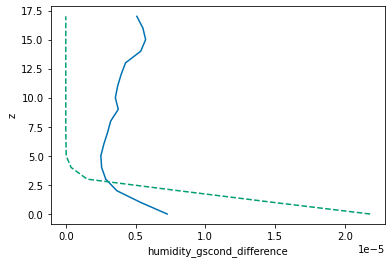

In [115]:
tm = np.logical_and(arc_target_ds.air_temperature_input > 215, arc_target_ds.air_temperature_input < 225)
rmse = np.sqrt(((arc_gscond_ds.humidity_gscond_difference - arc_target_ds.humidity_gscond_difference)**2).where(tm).mean("sample"))
rms = np.sqrt(((arc_target_ds.humidity_gscond_difference)**2).where(tm).mean("sample"))
(rmse * scale_factor).isel(z=slice(-29,-11)).plot(y="z")
(rms * scale_factor).isel(z=slice(-29,-11)).plot(y="z", linestyle="--")
plt.show()

### Relative Humidity

In [38]:
rh_10 = np.percentile(arc_target_ds["relative_humidity"].isel(z=slice(-29,-11)), 10)
rh_90 = np.percentile(arc_target_ds["relative_humidity"].isel(z=slice(-29,-11)), 90)


In [39]:
def plot_rh_vs_dq(rh, dq_target, dq_pred, extent=None):
    plt.figure(dpi=120)
    plt.hexbin(
        rh, dq_target,
        bins="log", cmap="viridis", gridsize=100, extent=extent
    )
    plt.colorbar()
    plt.title("Arctic RH vs. gscond humidity difference [Target]")
    plt.show()

    plt.figure(dpi=120)
    plt.hexbin(
        rh, dq_pred,
        bins="log", cmap="viridis", gridsize=100, extent=extent
    )
    plt.colorbar()
    plt.title("Arctic RH vs. gscond humidity difference [Predicted]")
    plt.show()

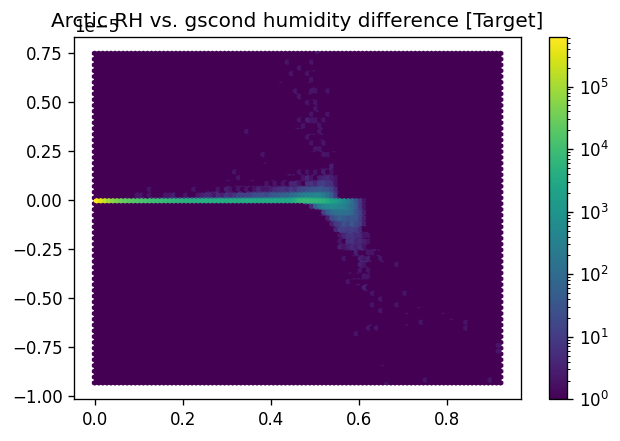

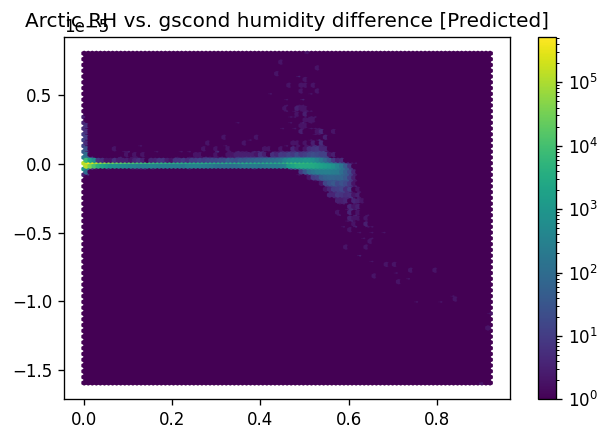

In [40]:
plot_rh_vs_dq(
    arc_target_ds["relative_humidity"].isel(z=slice(-29,-11)),
    arc_target_ds["humidity_gscond_difference"].isel(z=slice(-29,-11)),
    arc_gscond_ds["humidity_gscond_difference"].isel(z=slice(-29,-11)),
)

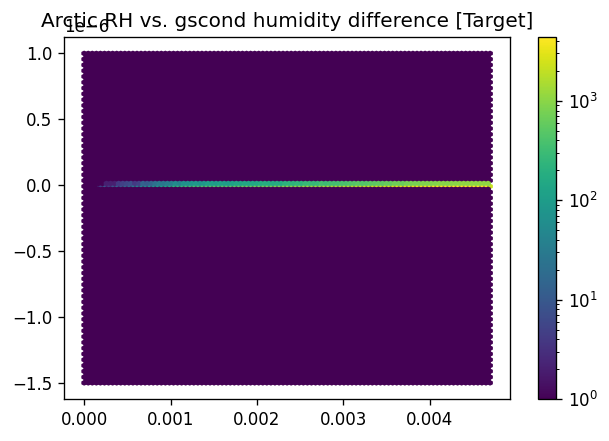

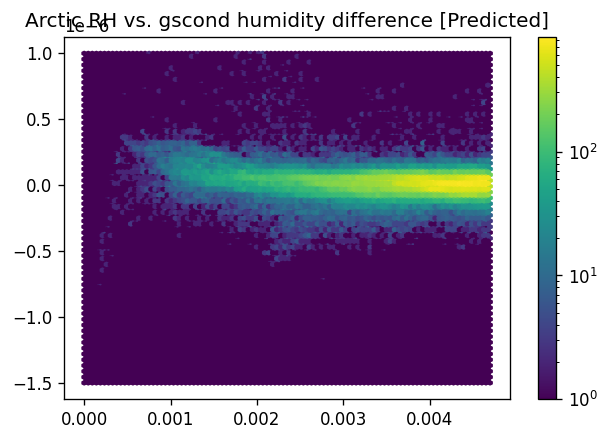

In [127]:
rh_thresh = arc_target_ds.relative_humidity.isel(z=slice(-29,-11)) < rh_10
extent = (0, rh_10, 1e-6, -1.5e-6)
plot_rh_vs_dq(
    arc_target_ds["relative_humidity"].isel(z=slice(-29,-11)).where(rh_thresh),
    arc_target_ds["humidity_gscond_difference"].isel(z=slice(-29,-11)).where(rh_thresh),
    arc_gscond_ds["humidity_gscond_difference"].isel(z=slice(-29,-11)).where(rh_thresh),
    extent=extent
)



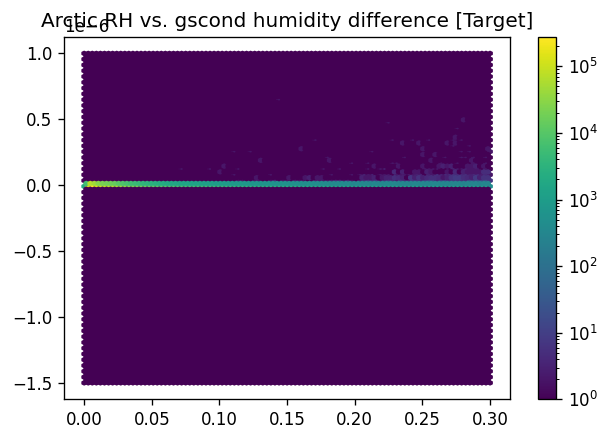

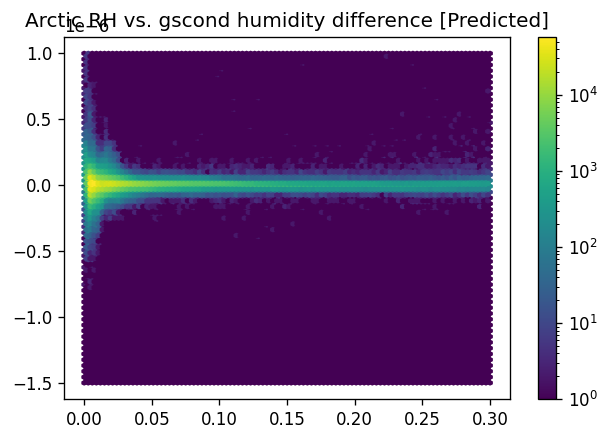

In [128]:
rh_thresh = arc_target_ds.relative_humidity.isel(z=slice(-29,-11)) < 0.3
extent = (0, 0.3, 1e-6, -1.5e-6)
plot_rh_vs_dq(
    arc_target_ds["relative_humidity"].isel(z=slice(-29,-11)).where(rh_thresh),
    arc_target_ds["humidity_gscond_difference"].isel(z=slice(-29,-11)).where(rh_thresh),
    arc_gscond_ds["humidity_gscond_difference"].isel(z=slice(-29,-11)).where(rh_thresh),
    extent=extent
)

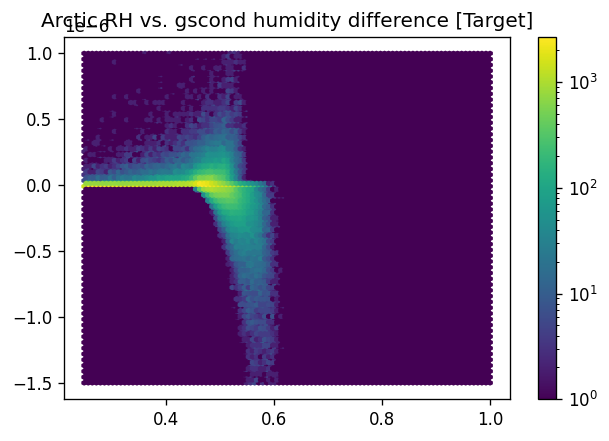

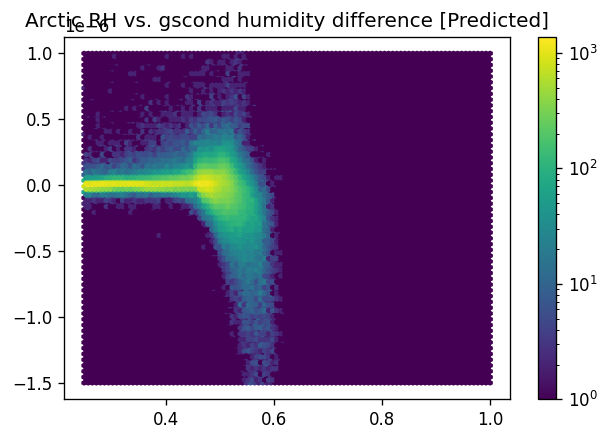

In [129]:
rh_thresh = arc_target_ds.relative_humidity.isel(z=slice(-29,-11)) > rh_90
extent = (rh_90, 1.0, 1e-6, -1.5e-6)
plot_rh_vs_dq(
    arc_target_ds["relative_humidity"].isel(z=slice(-29,-11)).where(rh_thresh),
    arc_target_ds["humidity_gscond_difference"].isel(z=slice(-29,-11)).where(rh_thresh),
    arc_gscond_ds["humidity_gscond_difference"].isel(z=slice(-29,-11)).where(rh_thresh),
    extent=extent
)

## Classifier Applied Plots

In [41]:
dq_pred = arc_gscond_ds["humidity_gscond_difference"].isel(z=slice(-29,-11))
dq_target = arc_target_ds["humidity_gscond_difference"].isel(z=slice(-29,-11))
in_q = combined_arc["specific_humidity_input"][:, -29:-11]
in_c = combined_arc["cloud_water_mixing_ratio_input"][:, -29:-11]

zero_tend = arc_classified[ZERO_TENDENCY][:, -29:-11]
zero_cloud = arc_classified[ZERO_CLOUD][:, -29:-11]


In [42]:
dq_pred_notend = dq_pred.values.copy()
dq_pred_notend[zero_tend] = 0.0
dq_pred_notend_zcloud = dq_pred_notend.copy()
dq_pred_notend_zcloud[zero_cloud] = in_c[zero_cloud]

In [43]:
dq_pred_na = non_arc_gscond_ds["humidity_gscond_difference"].isel(z=slice(-29,-11))
dq_target_na = non_arc_target_ds["humidity_gscond_difference"].isel(z=slice(-29,-11))
in_q_na = combined_non_arc["specific_humidity_input"][:, -29:-11]
in_c_na = combined_non_arc["cloud_water_mixing_ratio_input"][:, -29:-11]

zero_tend_na = non_arc_classified[ZERO_TENDENCY][:, -29:-11]
zero_cloud_na = non_arc_classified[ZERO_CLOUD][:, -29:-11]

dq_pred_notend_na = dq_pred_na.values.copy()
dq_pred_notend_na[zero_tend_na] = 0.0
dq_pred_notend_zcloud_na = dq_pred_notend_na.copy()
dq_pred_notend_zcloud_na[zero_cloud_na] = in_c_na[zero_cloud_na]

In [44]:
dq_pred_notend = xr.DataArray(dq_pred_notend, dims=dq_pred.dims, coords=dq_pred.coords)
dq_pred_notend_zcloud = xr.DataArray(dq_pred_notend_zcloud, dims=dq_pred.dims, coords=dq_pred.coords)
dq_na_pr_notend_zcloud = xr.DataArray(dq_pred_notend_zcloud_na, dims=dq_pred_na.dims, coords=dq_pred_na.coords)

In [45]:
cl_applied_arc_dq_rmse = np.sqrt(((dq_pred_notend_zcloud - dq_target)**2).mean("sample"))
cl_applied_na_dq_rmse = np.sqrt(((dq_pred_notend_zcloud_na - dq_target_na)**2).mean("sample"))

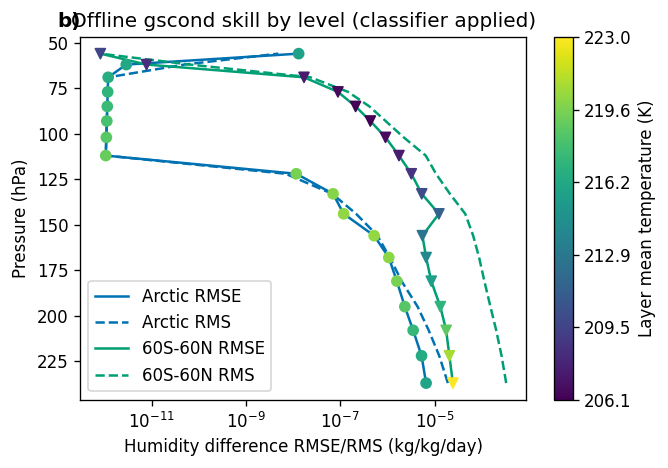

In [47]:
scale_factor = 60**2 * 24 / 900
ref_pressure = np.round(profiles["air_pressure"].numpy().mean(axis=0)[-29:-11]/100, 0).astype(int)
colormap = plt.cm.viridis

plt.figure(dpi=120)
line, = plt.plot(cl_applied_arc_dq_rmse*scale_factor, ref_pressure, label="Arctic RMSE")
plt.scatter(cl_applied_arc_dq_rmse*scale_factor, ref_pressure, c=colormap(norm_arc_temp), zorder=10)
plt.plot(arc_lev_rms["humidity_gscond_difference"]*scale_factor, ref_pressure, label="Arctic RMS", color=line.get_color(), linestyle="--")
cbar = plt.colorbar(label="Layer mean temperature (K)")
cbar.ax.set_yticklabels(color_bar_labels)


line, = plt.plot(cl_applied_na_dq_rmse*scale_factor, ref_pressure, label="60S-60N RMSE")
plt.scatter(cl_applied_na_dq_rmse*scale_factor, ref_pressure, c=colormap(norm_non_arc_temp), marker="v", zorder=10)
plt.plot(non_arc_lev_rms["humidity_gscond_difference"]*scale_factor, ref_pressure, label="60S-60N RMS", color=line.get_color(), linestyle="--")

plt.title("Offline gscond skill by level (classifier applied)")
plt.ylabel("")
plt.legend()
plt.xscale("log")

ax = plt.gca().invert_yaxis()

plt.ylabel("Pressure (hPa)")
plt.xlabel("Humidity difference RMSE/RMS (kg/kg/day)")

plt.text(-0.05, 1.07, "b)", transform=plt.gca().transAxes, fontsize=12, fontweight="bold", va="top", ha="left")
plt.show()

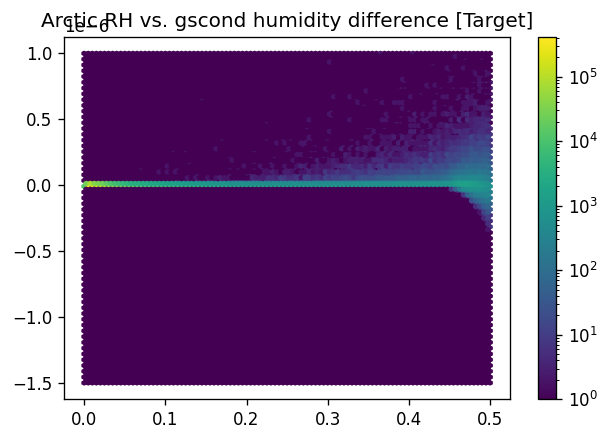

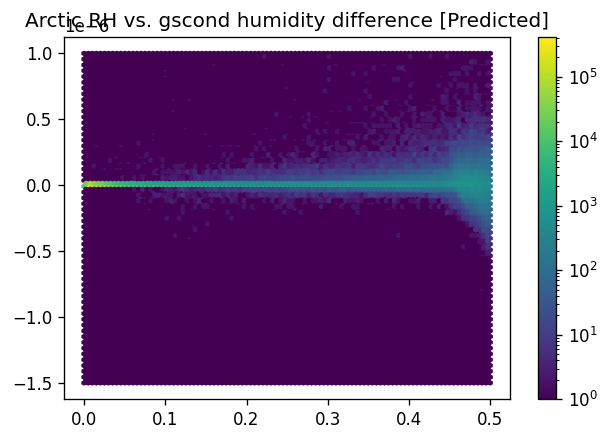

In [136]:
rh_thresh = arc_target_ds.relative_humidity.isel(z=slice(-29,-11)) < 0.5
extent = (0, 0.5, 1e-6, -1.5e-6)
plot_rh_vs_dq(
    arc_target_ds["relative_humidity"].isel(z=slice(-29,-11)).where(rh_thresh),
    arc_target_ds["humidity_gscond_difference"].isel(z=slice(-29,-11)).where(rh_thresh),
    dq_pred_notend.where(rh_thresh),
    extent=extent
)

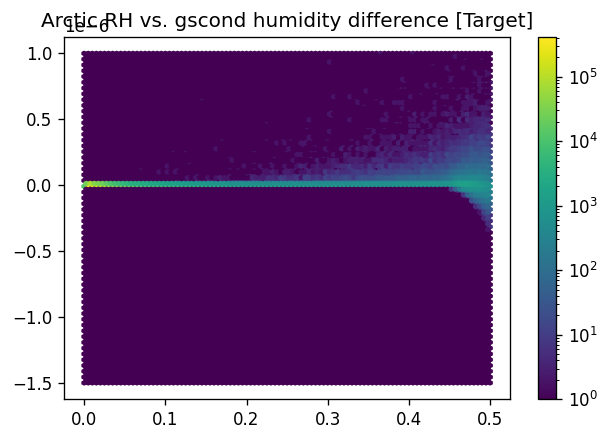

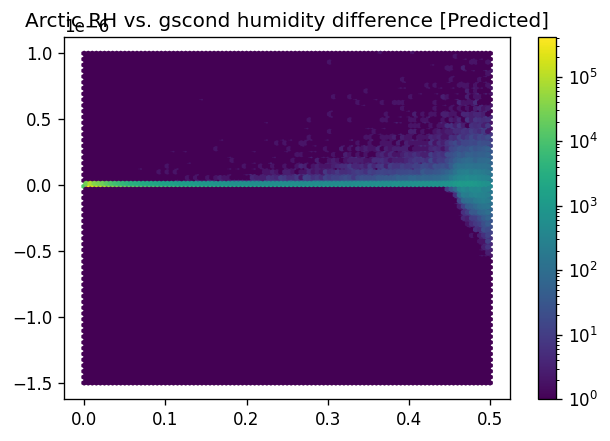

In [141]:
rh_thresh = arc_target_ds.relative_humidity.isel(z=slice(-29,-11)) < 0.5
extent = (0, 0.5, 1e-6, -1.5e-6)
plot_rh_vs_dq(
    arc_target_ds["relative_humidity"].isel(z=slice(-29,-11)).where(rh_thresh),
    arc_target_ds["humidity_gscond_difference"].isel(z=slice(-29,-11)).where(rh_thresh),
    dq_pred_notend_zcloud.where(rh_thresh),
    extent=extent
)

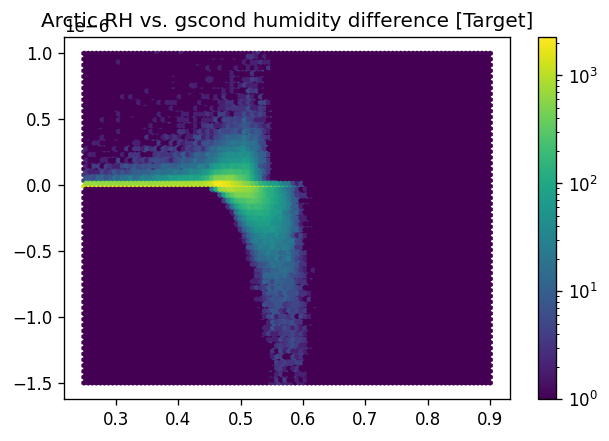

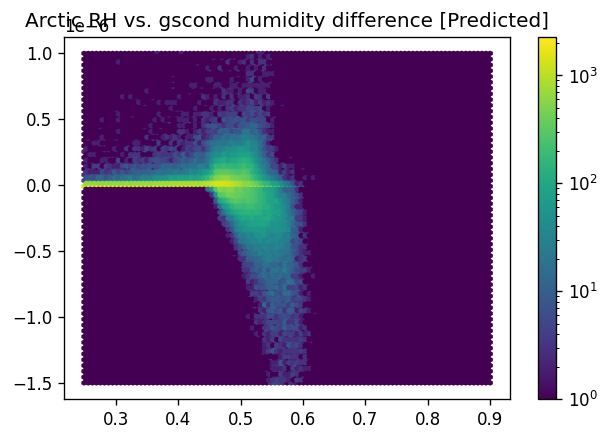

In [143]:
rh_thresh = arc_target_ds.relative_humidity.isel(z=slice(-29,-11)) > rh_90
extent = (rh_90, 0.9, 1e-6, -1.5e-6)
plot_rh_vs_dq(
    arc_target_ds["relative_humidity"].isel(z=slice(-29,-11)).where(rh_thresh),
    arc_target_ds["humidity_gscond_difference"].isel(z=slice(-29,-11)).where(rh_thresh),
    dq_pred_notend_zcloud.where(rh_thresh),
    extent=extent
)

### Use diagnostics to check rms vs. rmse at these locations over time
Saved has classifier and conservation applied

In [46]:
base = "zc-emu-classify-check-m{init}-6h-v2"

data = common.open_12init_from_group_prefix(base)

In [47]:
online = xr.concat([v[1].drop_vars("time") for v in data.values()], dim="init")

In [48]:
arc_tile = online.isel(tile=2)
lat = arc_tile.isel(init=0, time=0).lat
arc_data = arc_tile.where(arc_tile.lat > 60).isel(z=slice(11, 29))

In [49]:
emu_dq = arc_data["tendency_of_specific_humidity_due_to_gscond_emulator"]
phys_dq = arc_data["tendency_of_specific_humidity_due_to_gscond_physics"]

In [50]:
import dask
client = dask.distributed.Client()

In [51]:
rms = np.sqrt(vcm.weighted_average(phys_dq**2, arc_data.area, dims=["y", "x"]).mean("init")).load()
rmse = np.sqrt(vcm.weighted_average((phys_dq - emu_dq)**2, arc_data.area, dims=["y", "x"]).mean("init")).load()
bias = vcm.weighted_average(emu_dq - phys_dq, arc_data.area, dims=["y", "x"]).mean("init").load()

Text(0.5, 0, 'Humidity difference RMSE/RMS (kg/kg/day)')

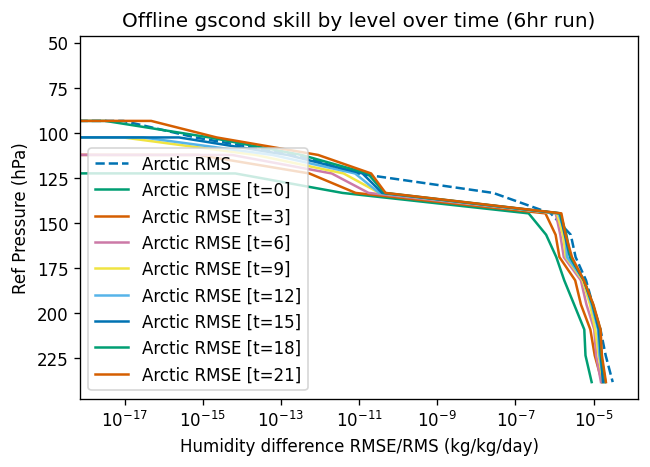

In [52]:
plt.figure(dpi=120)
scale_factor = 60**2 * 24
line = (rms.mean(dim="time") * scale_factor).plot(y="z", label="Arctic RMS", yincrease=False, linestyle="--")
for i in range(0, len(rmse.time), 3):
    (rmse.isel(time=i) * scale_factor).plot(y="z", label=f"Arctic RMSE [t={i}]", yincrease=False)

plt.title("Offline gscond skill by level over time (6hr run)")
plt.ylabel("Ref Pressure (hPa)")
plt.legend()
plt.xscale("log")

plt.xlabel("Humidity difference RMSE/RMS (kg/kg/day)")

Text(0.5, 0, 'Humidity difference bias (kg/kg/day)')

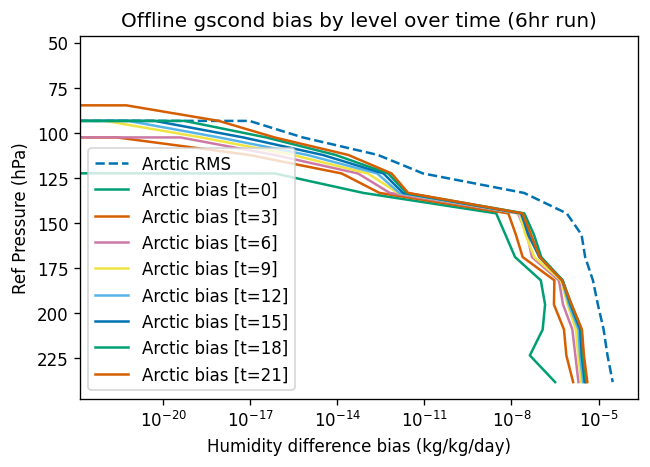

In [53]:
plt.figure(dpi=120)
scale_factor = 60**2 * 24
line = (rms.mean(dim="time") * scale_factor).plot(y="z", label="Arctic RMS", yincrease=False, linestyle="--")
for i in range(0, len(rmse.time), 3):
    (abs(bias.isel(time=i)) * scale_factor).plot(y="z", label=f"Arctic bias [t={i}]", yincrease=False)

plt.title("Offline gscond bias by level over time (6hr run)")
plt.ylabel("Ref Pressure (hPa)")
plt.legend()
plt.xscale("log")

plt.xlabel("Humidity difference bias (kg/kg/day)")

Text(0.5, 0, 'Humidity difference bias (kg/kg/day)')

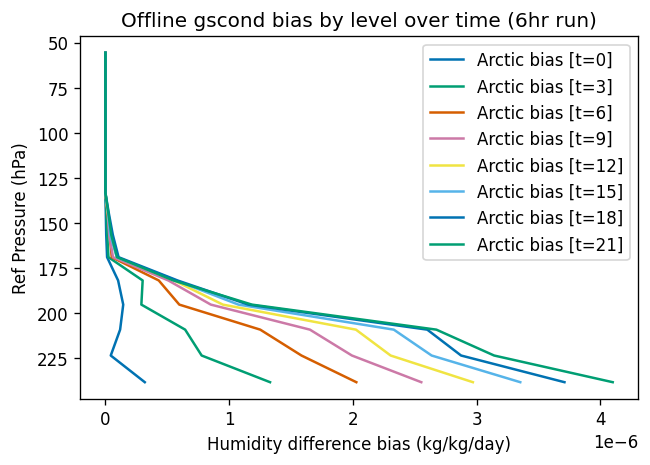

In [89]:
plt.figure(dpi=120)
scale_factor = 60**2 * 24
for i in range(0, len(rmse.time), 3):
    (abs(bias.isel(time=i)) * scale_factor).plot(y="z", label=f"Arctic bias [t={i}]", yincrease=False)

plt.title("Offline gscond bias by level over time (6hr run)")
plt.ylabel("Ref Pressure (hPa)")
plt.legend()

plt.xlabel("Humidity difference bias (kg/kg/day)")

### Try checking the RH vs. dq plots to see if it's visible which part of the classification is failing

In [52]:
def open_12init_group(group):
    months = [f"{i:02d}" for i in range(1, 13)]
    groups = [group.format(init=m) for m in months]

    sample = xr.Dataset(coords={"x": range(48), "y": range(48)}).stack({"sample": ["y", "x"]}).coords["sample"]
    ds = []
    for g in groups:
        url = common.get_group_url(g)
        state = xr.open_zarr(f"{url}/state_output.zarr", consolidated=True)
        state.coords["sample"] = sample
        state = state.unstack("sample").drop_vars("time")
        ds.append(state)

    return xr.concat(ds, dim="init")

In [53]:
data = open_12init_group(base + "-online")

In [54]:
state_arc = data.isel(tile=2, z=slice(-29, -11))
rh = vcm.calc.thermo.local.relative_humidity_from_pressure(
    state_arc.air_temperature_input,
    state_arc.specific_humidity_input,
    state_arc.air_pressure,
).where(np.rad2deg(state_arc.latitude) > 60)[:, :, ::-1] # reversed z dim

In [55]:
print(emu_dq.shape)
print(phys_dq.shape)
print(rh.shape)

(12, 24, 18, 48, 48)
(12, 24, 18, 48, 48)
(12, 24, 18, 48, 48)


In [56]:
rh.load()
phys_dq.load()
emu_dq.load()

<xarray.DataArray 'tendency_of_specific_humidity_due_to_gscond_emulator' (init: 12, time: 24, z: 18, y: 48, x: 48)>
array([[[[[nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          ...,
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan]],

         [[nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          ...,
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan]],

         [[nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          ...,
...
          ...,
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan]],

         [[nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          ...,
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan]],

         [[nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          ...,
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan]]]]], dtype=float32)
Coordinates:
    tile     int64 2
  * z        (z) float64 55.56 62.09 69.13 76.69 ... 195.1 209.0 223.4 238.1
  * y        (y) float32 1.0 2.0 3.0 4.0 5.0 6.0 ... 44.0 45.0 46.0 47.0 48.0
  * x        (x) float32 1.0 2.0 3.0 4.0 5.0 6.0 ... 44.0 45.0 46.0 47.0 48.0
Dimensions without coordinates: init, time
Attributes:
    cell_methods:  time: point
    long_name:     specific humidity tendency due to zhao_carr_gscond emulator
    units:         kg/kg/s

0


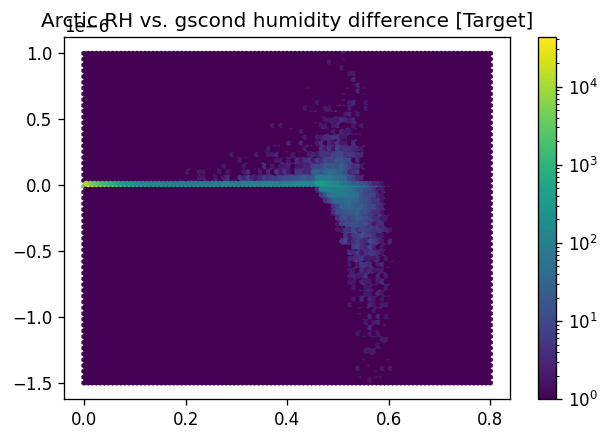

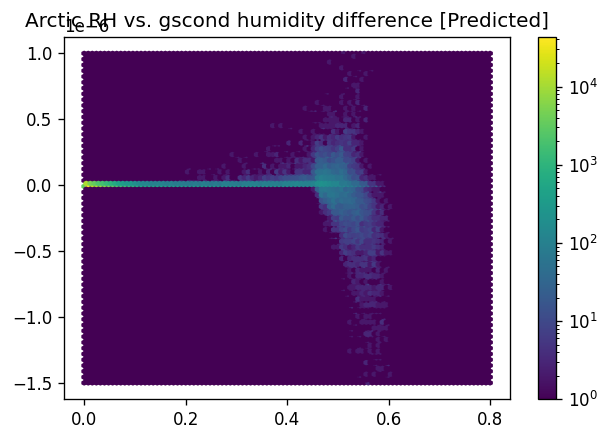

3


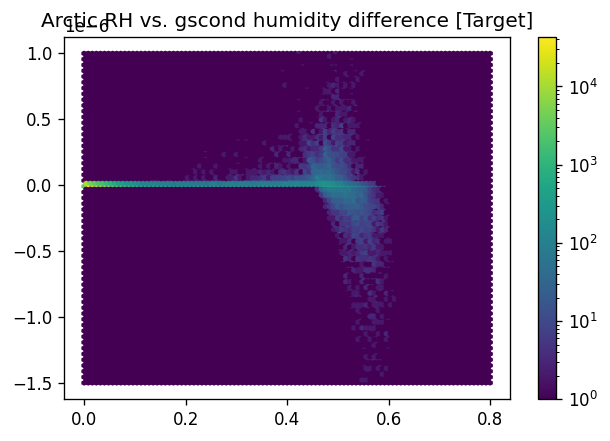

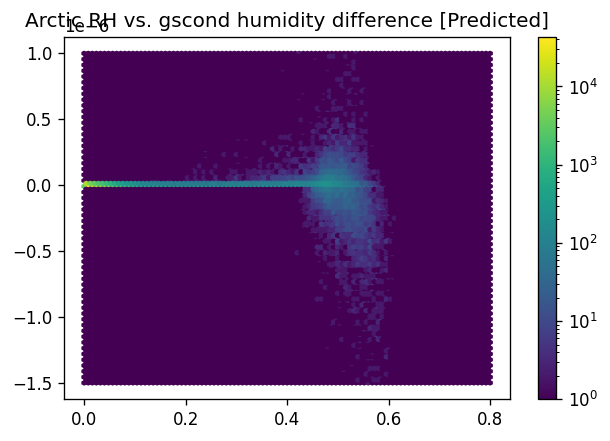

6


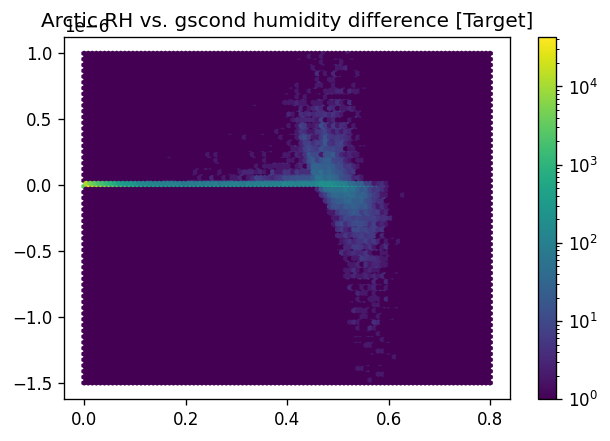

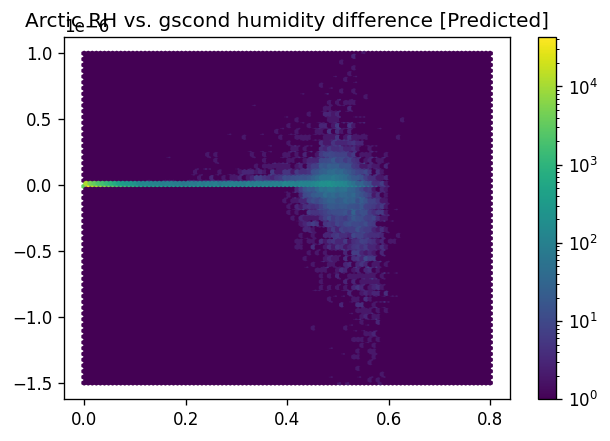

9


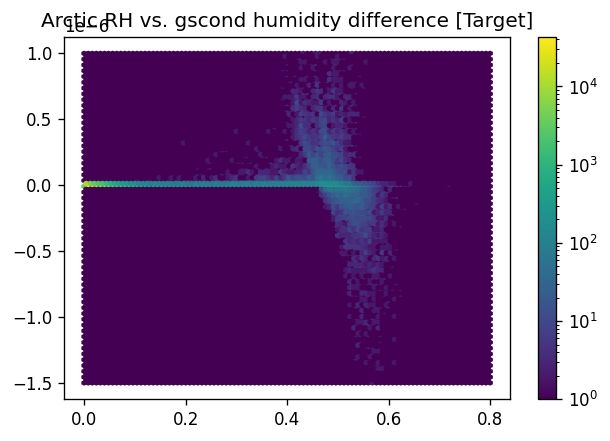

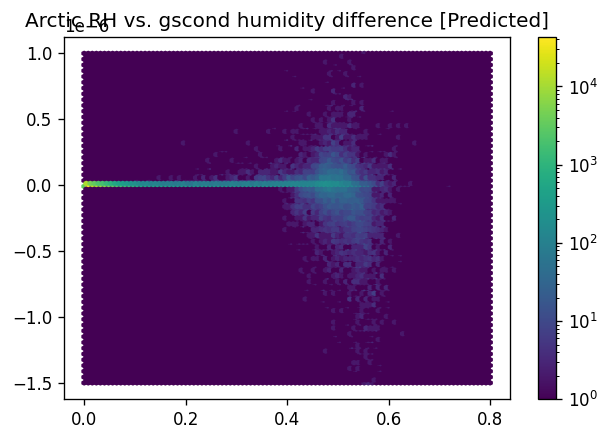

12


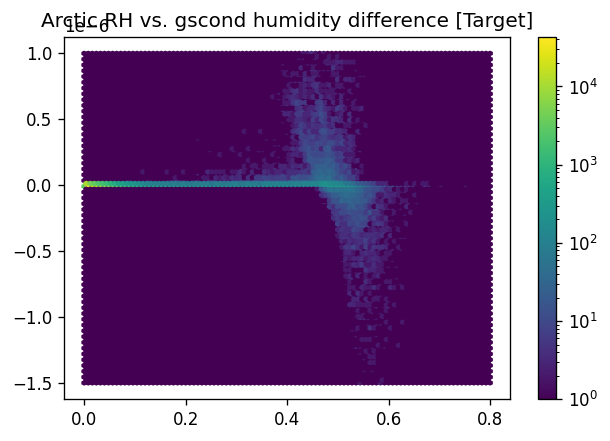

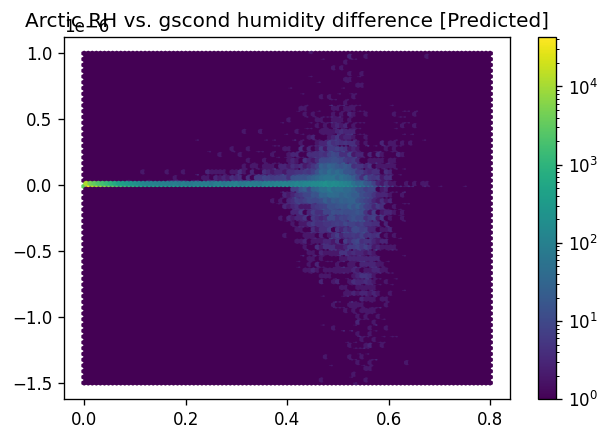

15


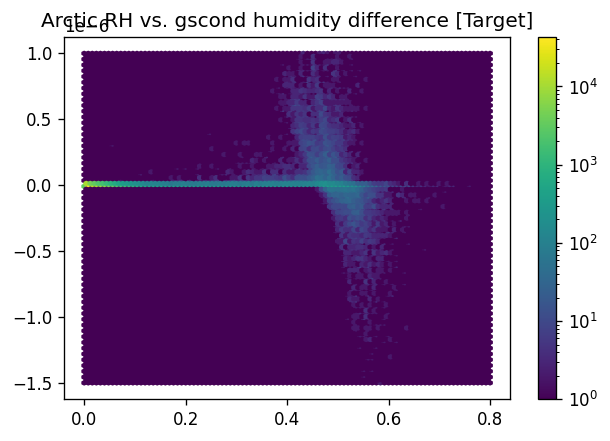

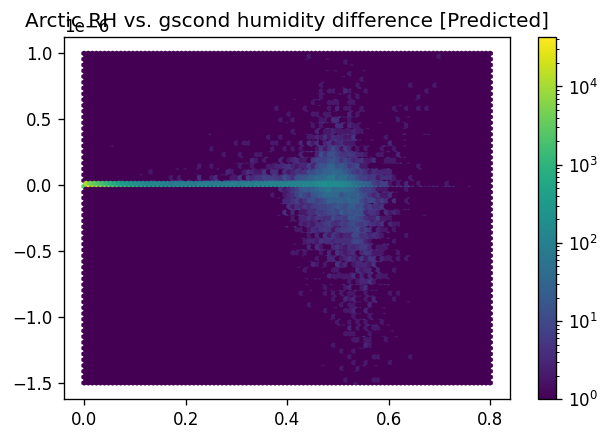

18


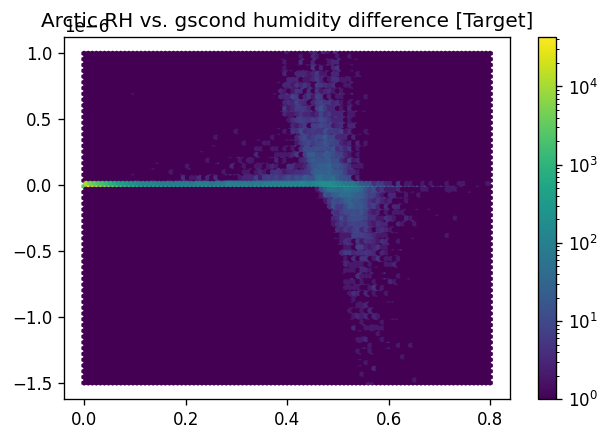

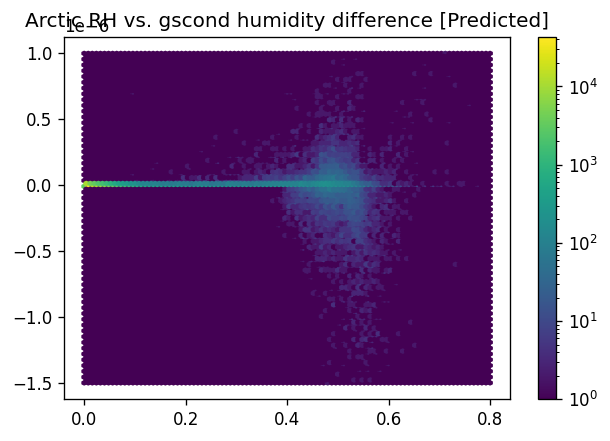

21


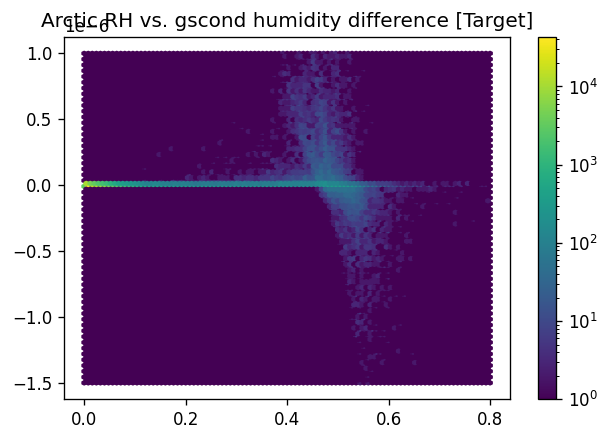

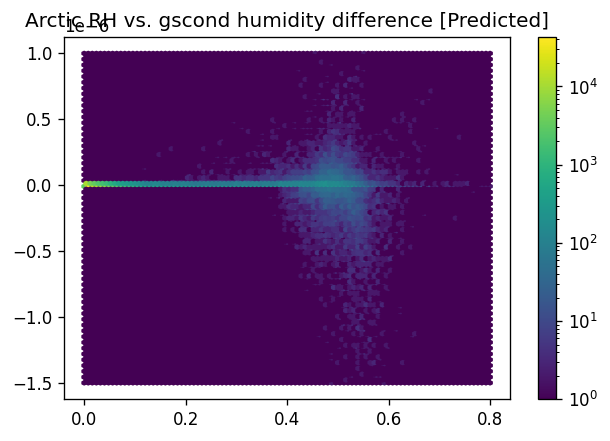

In [87]:

extent = (0, 0.8, 1e-6, -1.5e-6)
for i in range(0, len(rh.time), 3):
    print(f"{rh.time.values[i]}")
    plot_rh_vs_dq(
        rh.isel(time=i).values.flatten(),
        (phys_dq * 900).isel(time=i).values.flatten(),
        (emu_dq * 900).isel(time=i).values.flatten(),
        extent=extent
    )

2023-04-19 23:12:56,291 - distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)


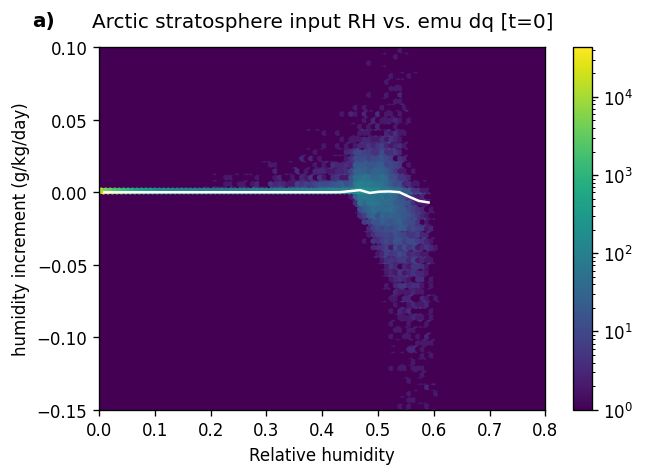

2023-04-19 23:13:01,854 - distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
2023-04-19 23:13:03,300 - distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)


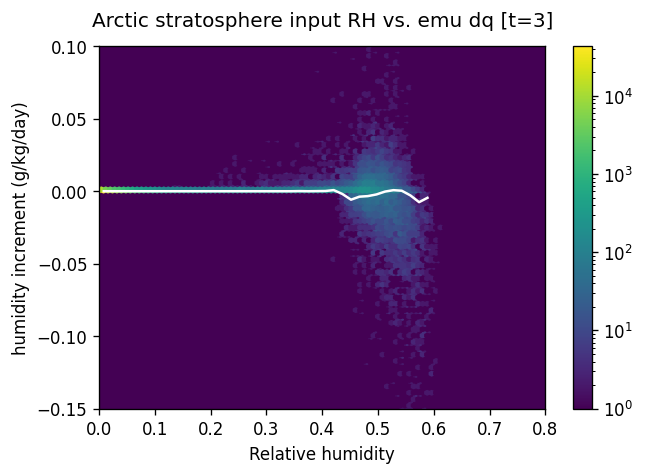

2023-04-19 23:13:06,020 - distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
2023-04-19 23:13:07,594 - distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)


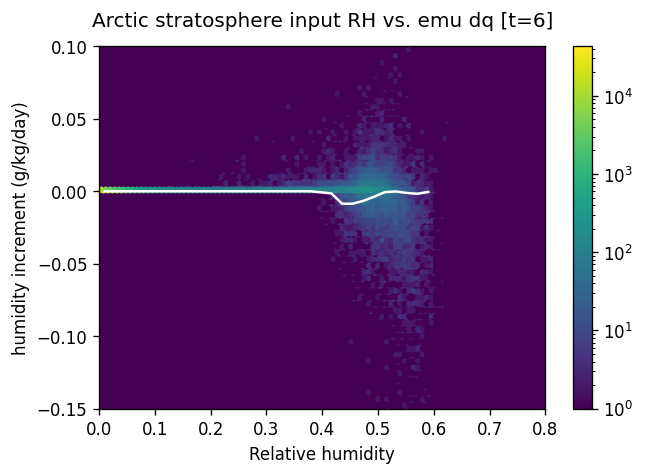

2023-04-19 23:13:10,265 - distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)


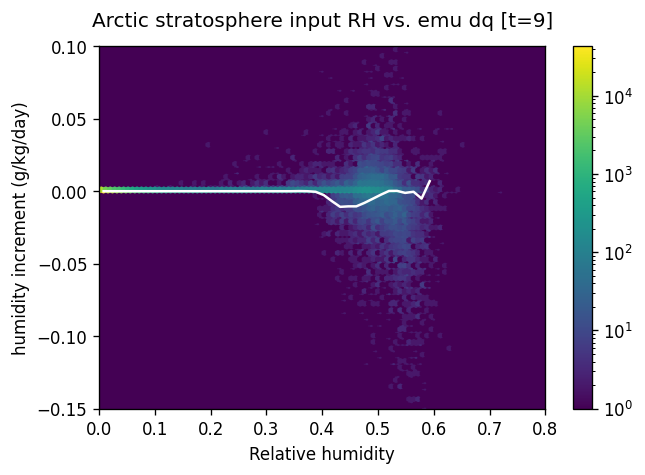

2023-04-19 23:13:12,972 - distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
2023-04-19 23:13:14,478 - distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)


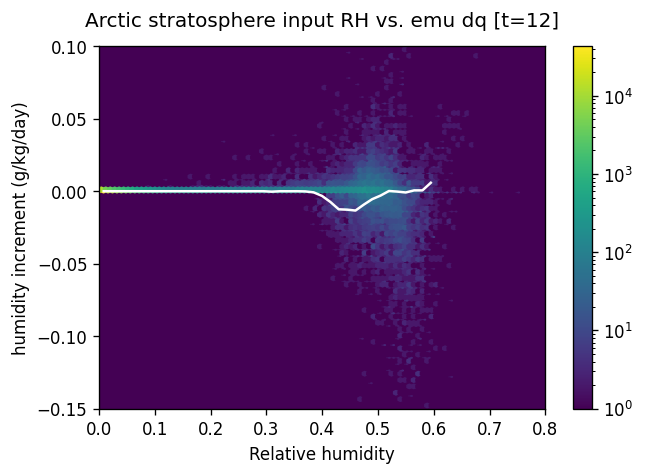

2023-04-19 23:13:17,185 - distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)


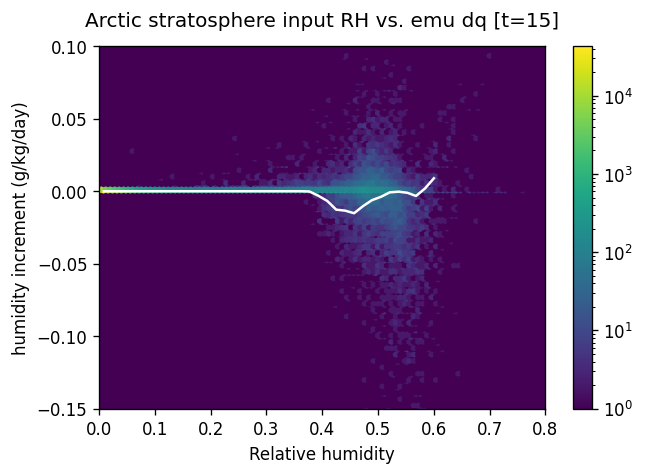

2023-04-19 23:13:19,659 - distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
2023-04-19 23:13:21,276 - distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)


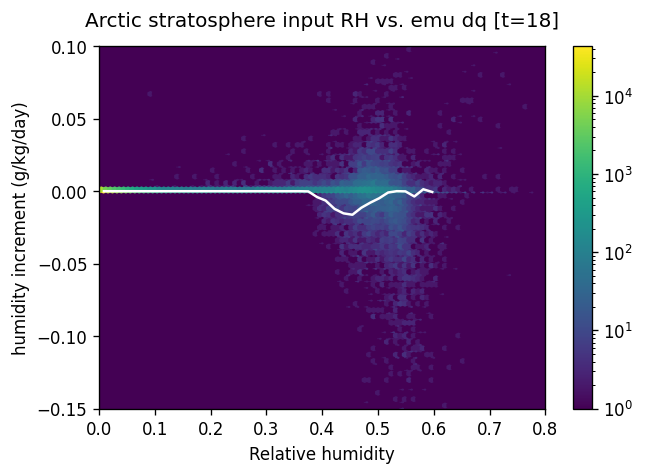

2023-04-19 23:13:23,924 - distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)


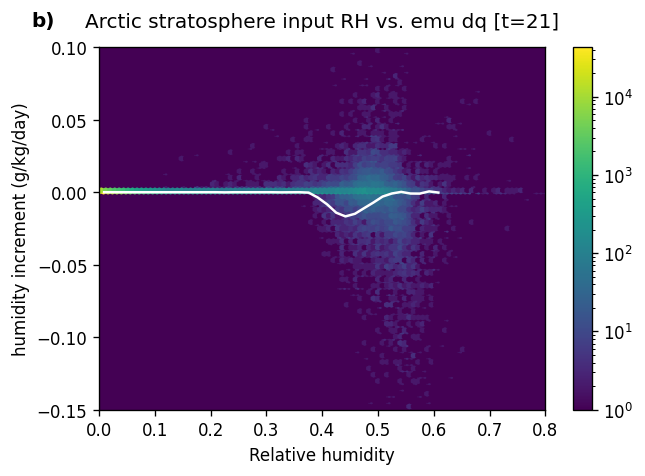

In [77]:
extent = (0, 0.8, 0.1, -0.15)
scale_factor = 60**2 * 24 * 1e3
for i in range(0, len(rh.time), 3):
    curr_rh = rh.isel(time=i).stack({"sample": ["init", "z", "y", "x"]}).dropna("sample")
    curr_pdq = (phys_dq.isel(time=i).stack({"sample": ["init", "z", "y", "x"]}).dropna("sample")).groupby_bins(curr_rh, 50)
    curr_edq = (emu_dq.isel(time=i).stack({"sample": ["init", "z", "y", "x"]}).dropna("sample")).groupby_bins(curr_rh, 50)
    bias_by_rh = (curr_edq.mean() - curr_pdq.mean()) * scale_factor
    pdq_bin_count = curr_pdq.count()
    edq_bin_count = curr_edq.count()
    bias_mask = (pdq_bin_count + edq_bin_count) / (pdq_bin_count.sum() + edq_bin_count.sum()) > 0.0005

    plt.figure(dpi=120)
    plt.hexbin(
        rh.isel(time=i).values.flatten(),
        (emu_dq * scale_factor).isel(time=i).values.flatten(),
        bins="log", cmap="viridis", gridsize=100, extent=extent
    )
    bias_by_rh.where(bias_mask).plot(color="white", label="bias")
    ax = plt.gca()
    plt.colorbar()
    plt.title(f"Arctic stratosphere input RH vs. emu dq [t={i}]", pad=12)
    plt.ylim(extent[2:][::-1])
    plt.xlim(0, 0.8)
    plt.xlabel("Relative humidity")
    plt.ylabel("humidity increment (g/kg/day)")
    if i == 0:
        ax.text(-0.1, 1.1, "a)", transform=ax.transAxes, fontsize=12, fontweight="bold", va="top", ha="right")
        common.savefig(f"sup_gscond_arc_bias_t{i}")
    elif i == 21:
        ax.text(-0.1, 1.1, "b)", transform=ax.transAxes, fontsize=12, fontweight="bold", va="top", ha="right")
        common.savefig(f"sup_gscond_arc_bias_t{i}")
    plt.show()

### Check RH 0.4 - 0.5 and see what fortran vs. predicted classes are for dq < 0

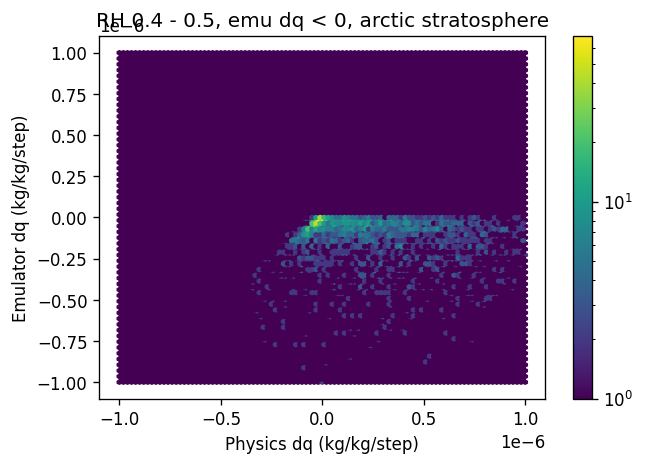

In [270]:
time_idx=21
last_rh = rh.isel(time=time_idx).drop_vars(["x", "y"])
last_emu_dq = emu_dq.isel(time=time_idx) * 900
last_phys_dq = phys_dq.isel(time=time_idx) * 900

mask = np.logical_and(emu_dq.isel(time=time_idx) < 0.0, np.logical_and(last_rh > 0.4, last_rh < 0.5))
plt.figure(dpi=120)
plt.hexbin(last_phys_dq.where(mask), last_emu_dq.where(mask), bins="log", cmap="viridis", gridsize=100, extent = (-1e-6, 1e-6, -1e-6, 1e-6))
plt.colorbar()
plt.title("RH 0.4 - 0.5, emu dq < 0, arctic stratosphere")
plt.ylabel("Emulator dq (kg/kg/step)")
plt.xlabel("Physics dq (kg/kg/step)")
plt.show()

arc_lat = (np.rad2deg(state_arc.latitude) > 60).drop_vars(["y", "x"])
last_cloud_in = state_arc.cloud_water_mixing_ratio_input.where(arc_lat).isel(time=time_idx)[:, ::-1]
ztend = abs(phys_dq.isel(time=time_idx) * 900) < 1e-15
zcloud = abs(phys_dq.isel(time=time_idx) * 900 - last_cloud_in.drop_vars(["y", "x"])) < 1e-15
zcloud = np.logical_and(zcloud, np.logical_not(ztend))
zcloud = zcloud.where(arc_lat.isel(time=0)).stack({"sample": [...]}).dropna("sample")
ztend = ztend.where(arc_lat.isel(time=0)).stack({"sample": [...]}).dropna("sample")

pred_zcloud = state_arc.zero_cloud.where(arc_lat).isel(time=time_idx)[:, ::-1].stack({"sample": [...]}).dropna("sample").astype(bool)
pred_ztend = state_arc.zero_tendency.where(arc_lat).isel(time=time_idx)[:, ::-1].stack({"sample": [...]}).dropna("sample").astype(bool)

In [273]:
flat_mask = mask.where(arc_lat.isel(time=0)).stack({"sample": [...]}).dropna("sample").values.astype(bool)
def calc_cl_metrics(targ, pred):
    precision = calc_precision(targ, pred)
    recall = calc_recall(targ, pred)
    targ_proportion = targ.sum() / targ.size
    pred_proportion = pred.sum() / pred.size

    series = pd.Series({
        "True proportion": targ_proportion,
        "Pred proportion": pred_proportion,
        "precision": precision,
        "recall": recall,
    })
    return series


metrics = [
    calc_cl_metrics(zcloud.values[flat_mask], pred_zcloud.values[flat_mask]),
    calc_cl_metrics(ztend.values[flat_mask], pred_ztend.values[flat_mask])
]

pd.DataFrame(metrics, index=["zero cloud", "zero tendency"])


True proportion  Pred proportion  precision    recall
zero cloud            0.000435         0.026980   0.000000  0.000000
zero tendency         0.016101         0.884247   0.016732  0.918919

In [264]:
zcloud.values[flat_mask].sum() / zcloud.values[flat_mask].size

0.0004351610095735422

### Try another strategy of checking classified emulator output in this relative humidity range

In [43]:
time_idx=21
arc_lat = (np.rad2deg(state_arc.latitude) > 60).drop_vars(["y", "x"])
final_state_dq = (state_arc.specific_humidity_after_gscond - state_arc.specific_humidity_input).where(arc_lat).isel(time=time_idx).load()
pred_zcloud = state_arc.zero_cloud.where(arc_lat).isel(time=time_idx).load()
pred_ztend = state_arc.zero_tendency.where(arc_lat).isel(time=time_idx).load()
rh = vcm.calc.thermo.local.relative_humidity_from_pressure(
    state_arc.air_temperature_input,
    state_arc.specific_humidity_input,
    state_arc.air_pressure,
).where(arc_lat).isel(time=time_idx).load()

last_cloud_in = state_arc.cloud_water_mixing_ratio_input.where(arc_lat).isel(time=time_idx).load()

# apply 0.4 < rh < 0.5 and final_state_dq < 0 mask
mask = np.logical_and(np.logical_and(rh < 0.5, rh > 0.4), np.logical_or(final_state_dq < 0, final_state_dq > 0))
mask.sum()

<xarray.DataArray ()>
array(6589)

In [44]:
targ_dq = phys_dq.isel(time=time_idx).load()[:, ::-1]

In [45]:
ztend = abs(targ_dq.drop_vars(["x", "y"]) * 900) < 1e-15
ztend = ztend.where(arc_lat.isel(time=time_idx)).load()
zcloud = abs(targ_dq.drop_vars(["x", "y"]) * 900 - last_cloud_in) < 1e-15
zcloud = np.logical_and(zcloud, np.logical_not(ztend)).where(arc_lat.isel(time=time_idx)).load()

In [341]:
metrics = [
    calc_cl_metrics(zcloud.stack({"sample": [...]}).dropna("sample").values, pred_zcloud.stack({"sample": [...]}).dropna("sample").values),
    calc_cl_metrics(ztend.stack({"sample": [...]}).dropna("sample").values, pred_ztend.stack({"sample": [...]}).dropna("sample").values)
]

pd.DataFrame(metrics, index=["zero cloud", "zero tendency"])

True proportion  Pred proportion  precision    recall
zero cloud            0.155871         0.030940   0.215249  0.042727
zero tendency         0.796163         0.918362   0.800722  0.923620

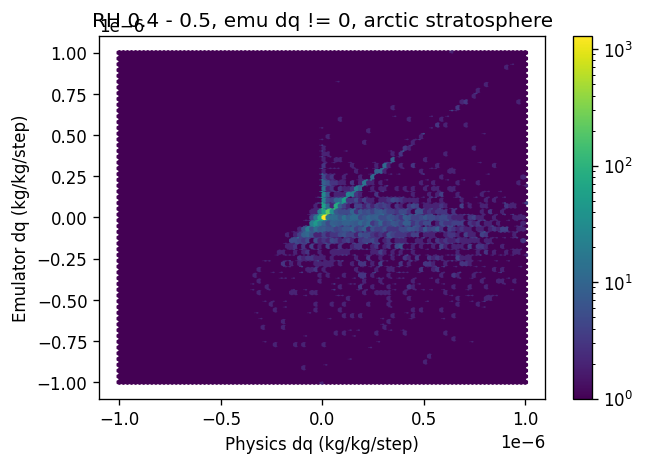

In [343]:
plt.figure(dpi=120)
plt.hexbin(targ_dq.drop_vars(["x", "y"]).where(mask) * 900, final_state_dq.where(mask), bins="log", cmap="viridis", gridsize=100, extent = (-1e-6, 1e-6, -1e-6, 1e-6))
plt.colorbar()
plt.title("RH 0.4 - 0.5, emu dq != 0, arctic stratosphere")
plt.ylabel("Emulator dq (kg/kg/step)")
plt.xlabel("Physics dq (kg/kg/step)")
plt.show()

In [344]:
metrics = [
    calc_cl_metrics(
        zcloud.where(mask).stack({"sample": [...]}).dropna("sample").values, 
        pred_zcloud.where(mask).stack({"sample": [...]}).dropna("sample").values
    ),
    calc_cl_metrics(
        ztend.where(mask).stack({"sample": [...]}).dropna("sample").values,
        pred_ztend.where(mask).stack({"sample": [...]}).dropna("sample").values
    )
]

pd.DataFrame(metrics, index=["zero cloud", "zero tendency"])

<ipython-input-23-bf665484ce3b>:5: RuntimeWarning: invalid value encountered in long_scalars
  return true_positive / (true_positive + false_positive)


True proportion  Pred proportion  precision    recall
zero cloud            0.327060         0.403855   0.334461  0.412993
zero tendency         0.092882         0.000000        NaN  0.000000

<xarray.DataArray ()>
array(6833)


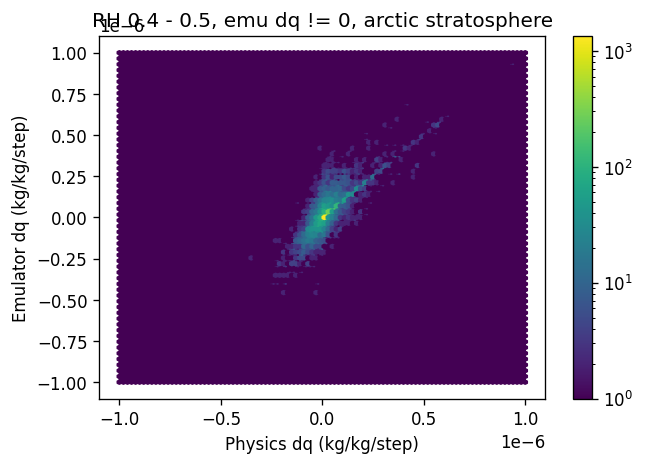

<ipython-input-23-bf665484ce3b>:5: RuntimeWarning: invalid value encountered in long_scalars
  return true_positive / (true_positive + false_positive)


True proportion  Pred proportion  precision    recall
zero cloud            0.334553         0.405678   0.329365  0.399388
zero tendency         0.037173         0.000000        NaN  0.000000

In [348]:
time_idx=0
arc_lat = (np.rad2deg(state_arc.latitude) > 60).drop_vars(["y", "x"])
final_state_dq = (state_arc.specific_humidity_after_gscond - state_arc.specific_humidity_input).where(arc_lat).isel(time=time_idx).load()
pred_zcloud = state_arc.zero_cloud.where(arc_lat).isel(time=time_idx).load()
pred_ztend = state_arc.zero_tendency.where(arc_lat).isel(time=time_idx).load()
rh = vcm.calc.thermo.local.relative_humidity_from_pressure(
    state_arc.air_temperature_input,
    state_arc.specific_humidity_input,
    state_arc.air_pressure,
).where(arc_lat).isel(time=time_idx).load()

last_cloud_in = state_arc.cloud_water_mixing_ratio_input.where(arc_lat).isel(time=time_idx).load()
targ_dq = phys_dq.isel(time=time_idx).load()[:, ::-1]

ztend = abs(targ_dq.drop_vars(["x", "y"]) * 900) < 1e-15
ztend = ztend.where(arc_lat.isel(time=time_idx)).load()
zcloud = abs(targ_dq.drop_vars(["x", "y"]) * 900 - last_cloud_in) < 1e-15
zcloud = np.logical_and(zcloud, np.logical_not(ztend)).where(arc_lat.isel(time=time_idx)).load()

# apply 0.4 < rh < 0.5 and final_state_dq < 0 mask
mask = np.logical_and(np.logical_and(rh < 0.5, rh > 0.4), np.logical_or(final_state_dq < 0, final_state_dq > 0))
print(mask.sum())

plt.figure(dpi=120)
plt.hexbin(targ_dq.drop_vars(["x", "y"]).where(mask) * 900, final_state_dq.where(mask), bins="log", cmap="viridis", gridsize=100, extent = (-1e-6, 1e-6, -1e-6, 1e-6))
plt.colorbar()
plt.title("RH 0.4 - 0.5, emu dq != 0, arctic stratosphere")
plt.ylabel("Emulator dq (kg/kg/step)")
plt.xlabel("Physics dq (kg/kg/step)")
plt.show()

metrics = [
    calc_cl_metrics(
        zcloud.where(mask).stack({"sample": [...]}).dropna("sample").values, 
        pred_zcloud.where(mask).stack({"sample": [...]}).dropna("sample").values
    ),
    calc_cl_metrics(
        ztend.where(mask).stack({"sample": [...]}).dropna("sample").values,
        pred_ztend.where(mask).stack({"sample": [...]}).dropna("sample").values
    )
]

pd.DataFrame(metrics, index=["zero cloud", "zero tendency"])

## Check to see if any discernible input drift in the arctic stratosphere region 

In [46]:
state_arc.air_temperature_input.load()
state_arc.specific_humidity_input.load()
state_arc.cloud_water_mixing_ratio_input.load()
print("Done")

Done


In [82]:
print(list(state_arc.data_vars))

['air_pressure', 'air_temperature_after_gscond', 'air_temperature_after_last_gscond', 'air_temperature_after_precpd', 'air_temperature_input', 'cloud_precpd_difference', 'cloud_water_mixing_ratio_after_gscond', 'cloud_water_mixing_ratio_after_precpd', 'cloud_water_mixing_ratio_input', 'gscond_classes', 'humidity_gscond_difference', 'humidity_gscond_difference_tscaled', 'humidity_precpd_difference', 'latitude', 'longitude', 'negative_tendency', 'nontrivial_tendency', 'positive_tendency', 'pressure_thickness_of_atmospheric_layer', 'rank', 'ratio_of_snowfall_to_rainfall', 'rhc', 'specific_humidity_after_gscond', 'specific_humidity_after_last_gscond', 'specific_humidity_after_precpd', 'specific_humidity_input', 'surface_air_pressure', 'surface_air_pressure_after_last_gscond', 'temperature_precpd_difference', 'tendency_of_rain_water_mixing_ratio_due_to_microphysics', 'total_precipitation', 'zero_cloud', 'zero_tendency']


In [85]:
tmp = transform.forward({
    "air_temperature_input": state_arc.air_temperature_input,
    "specific_humidity_input": state_arc.specific_humidity_input,
    "cloud_water_mixing_ratio_input": state_arc.cloud_water_mixing_ratio_input,
    "humidity_gscond_difference": np.array(state_arc.humidity_gscond_difference),
})

online_data = xr.Dataset({k: xr.DataArray(v, dims=["init", "time", "z", "y", "x"]) for k,v in tmp.items()})

In [86]:
online_data = online_data.where(arc_lat).isel(time=[0, 11, 23])

In [87]:
online_data.load()

<xarray.Dataset>
Dimensions:                             (init: 12, time: 3, z: 18, y: 48, x: 48)
Coordinates:
  * y                                   (y) int64 0 1 2 3 4 5 ... 43 44 45 46 47
  * x                                   (x) int64 0 1 2 3 4 5 ... 43 44 45 46 47
Dimensions without coordinates: init, time, z
Data variables:
    air_temperature_input               (init, time, z, y, x) float32 nan ......
    specific_humidity_input             (init, time, z, y, x) float32 nan ......
    cloud_water_mixing_ratio_input      (init, time, z, y, x) float32 nan ......
    humidity_gscond_difference          (init, time, z, y, x) float32 nan ......
    log_cloud_input                     (init, time, z, y, x) float32 nan ......
    log_humidity_input                  (init, time, z, y, x) float32 nan ......
    humidity_gscond_difference_tscaled  (init, time, z, y, x) float32 nan ......

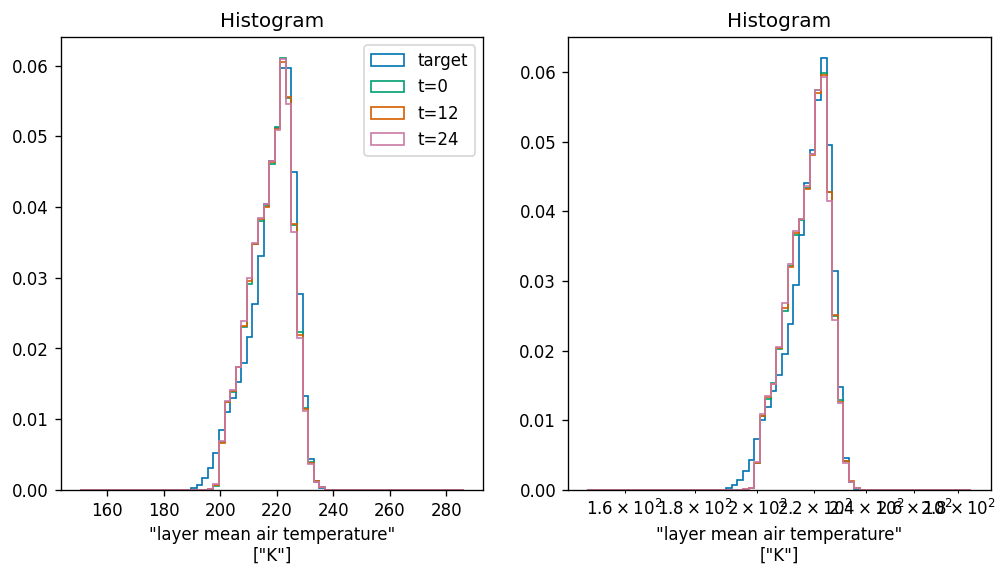

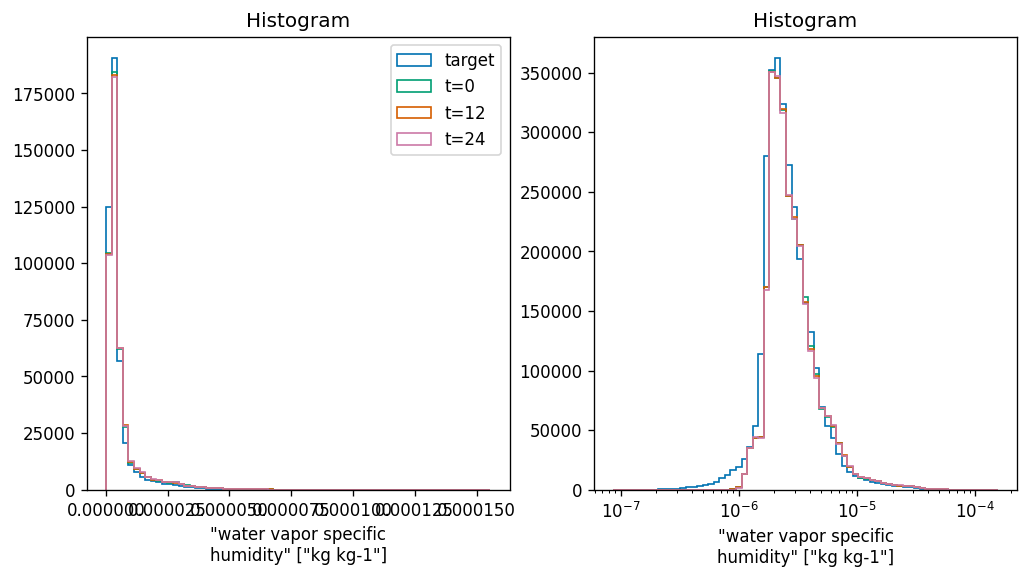

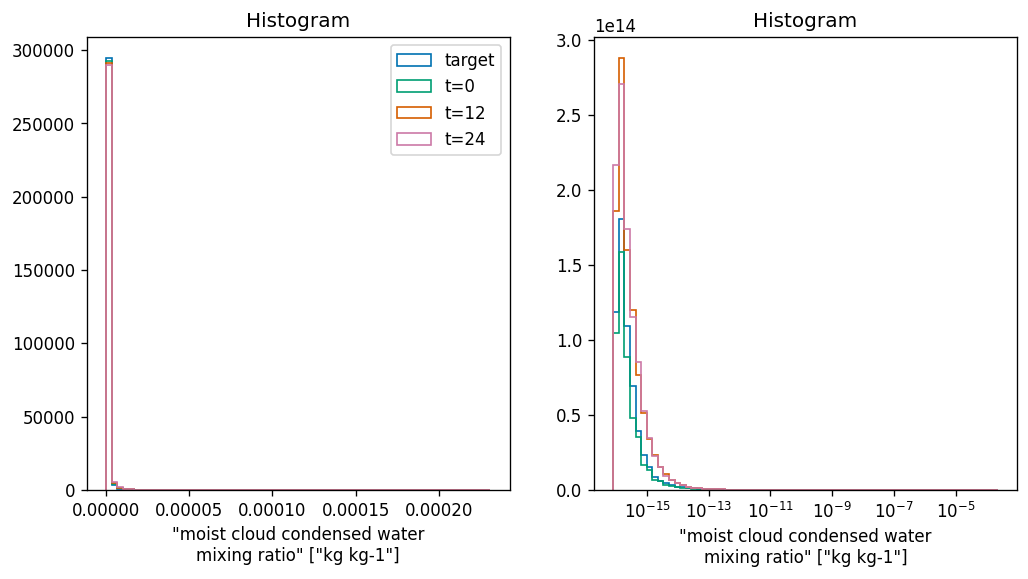

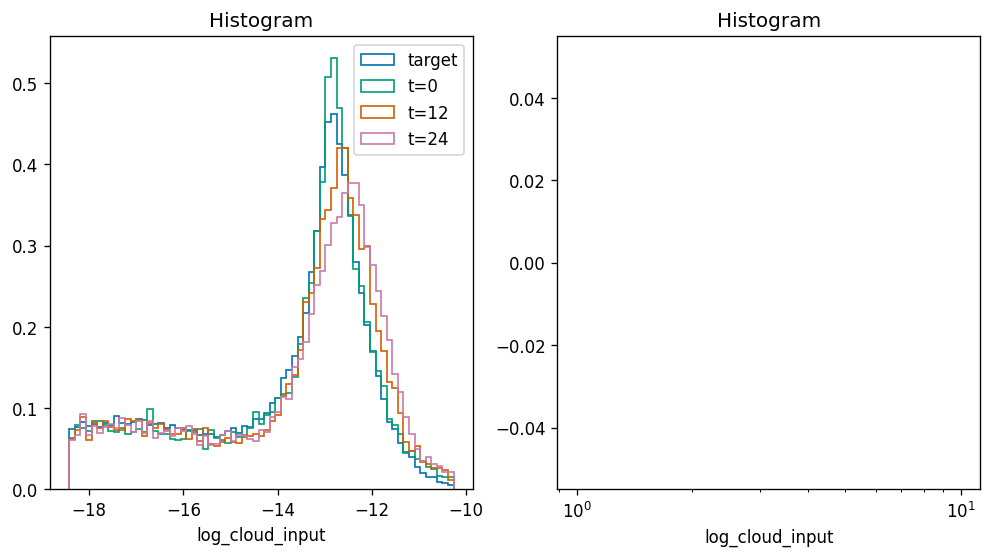

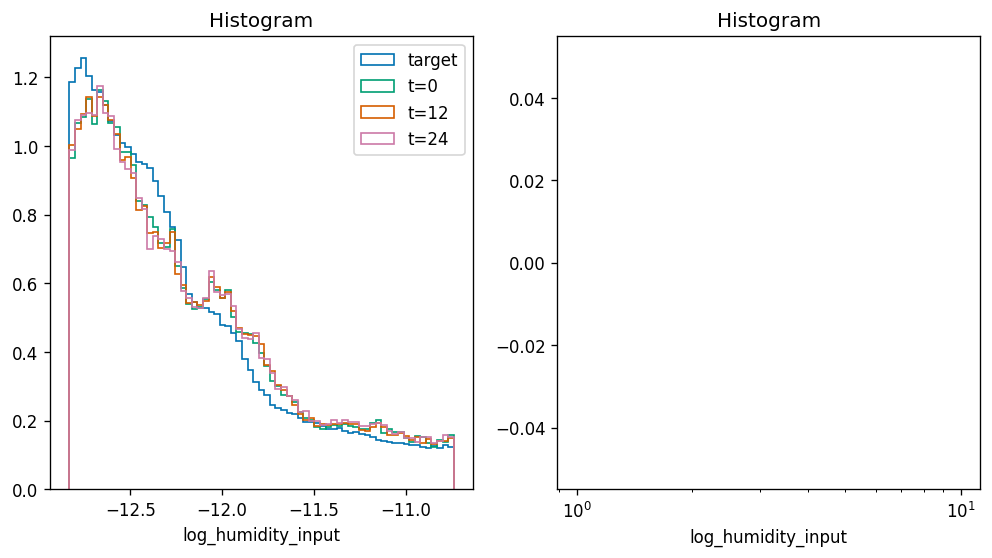

In [69]:
# Use the offline data to set a base distribution
# Plot distributions at T = 0, T = 3 hr, T = 6 hours
# Use a log plot and an absolute magnitued plot


inputs = [
    "air_temperature_input",
    "specific_humidity_input",
    "cloud_water_mixing_ratio_input",
    "log_cloud_input",
    "log_humidity_input",
]

def get_bins(data, logspace=False):

    if logspace:
        dmin = abs(data.min())
            
        bin_min = np.log10(dmin * 0.8)
        bin_max = np.log10(abs(data.max()) * 1.2)
        bins = np.logspace(bin_min, bin_max, 70)
    else:
        bin_min = data.min() * 0.8
        bin_max = data.max() * 1.2
        bins = np.linspace(bin_min, bin_max, 70)

    return bins

for k in inputs:
    fig, ax = plt.subplots(1,2, dpi=120, figsize=(10, 5))
    target_data = arc_target_ds[k].isel(z=slice(-29, -11))
    lin_bins = get_bins(target_data.values)
    
    target_data.plot.hist(bins=lin_bins, density=True, ax=ax[0], histtype="step", label="target")
    for_log = target_data.where(target_data > 1e-16)
    log_bins = get_bins(for_log, logspace=True)
    for_log.plot.hist(bins=log_bins, density=True, ax=ax[1], histtype="step", label="target")
    ax[1].set_xscale("log")

    for tidx in [0, 1, 2]:
        curr_odata = online_data.isel(time=tidx)[k]
        
        for_log = curr_odata.where(curr_odata > 1e-16)
        curr_odata.plot.hist(bins=lin_bins, density=True, ax=ax[0], histtype="step", label=f"t={tidx*12}")
        for_log.plot.hist(bins=log_bins, density=True, ax=ax[1], histtype="step", label=f"t={tidx*12}")

    ax[0].legend()
    plt.show()


In [76]:
rh = vcm.calc.thermo.local.relative_humidity_from_pressure(
    state_arc.air_temperature_input,
    state_arc.specific_humidity_input,
    state_arc.air_pressure,
).isel(time=[0, 11, 23])

In [ ]:
rh.load()

In [79]:
online_data.log_cloud_input.where(np.logical_and(rh > 0.4, rh < 0.5)).max()

<xarray.DataArray 'log_cloud_input' ()>
array(-9.261124, dtype=float32)

In [81]:
online_data

<xarray.Dataset>
Dimensions:                         (init: 12, time: 3, z: 18, y: 48, x: 48)
Coordinates:
  * y                               (y) int64 0 1 2 3 4 5 ... 42 43 44 45 46 47
  * x                               (x) int64 0 1 2 3 4 5 ... 42 43 44 45 46 47
Dimensions without coordinates: init, time, z
Data variables:
    air_temperature_input           (init, time, z, y, x) float32 nan ... nan
    specific_humidity_input         (init, time, z, y, x) float32 nan ... nan
    cloud_water_mixing_ratio_input  (init, time, z, y, x) float32 nan ... nan
    log_cloud_input                 (init, time, z, y, x) float32 nan ... nan
    log_humidity_input              (init, time, z, y, x) float32 nan ... nan

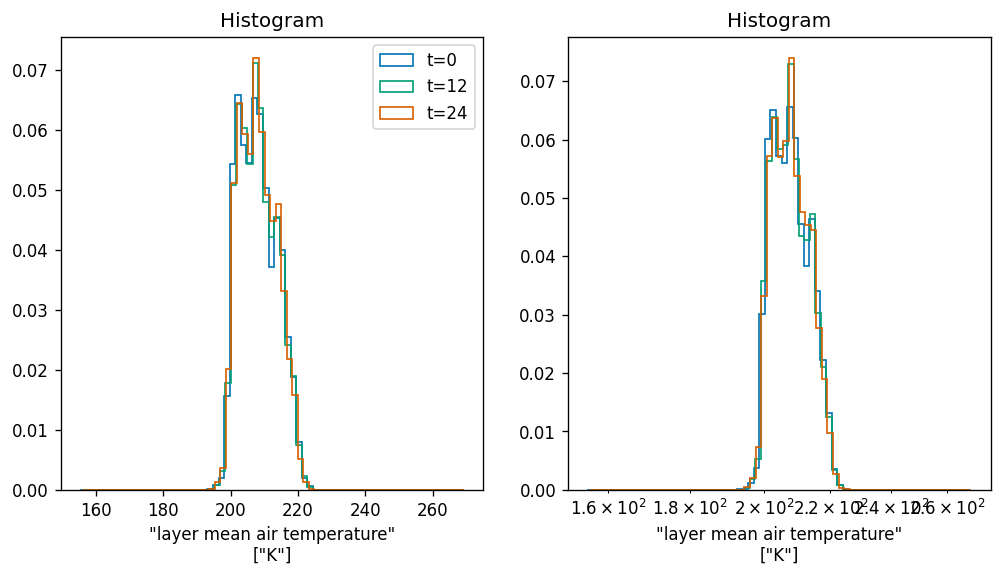

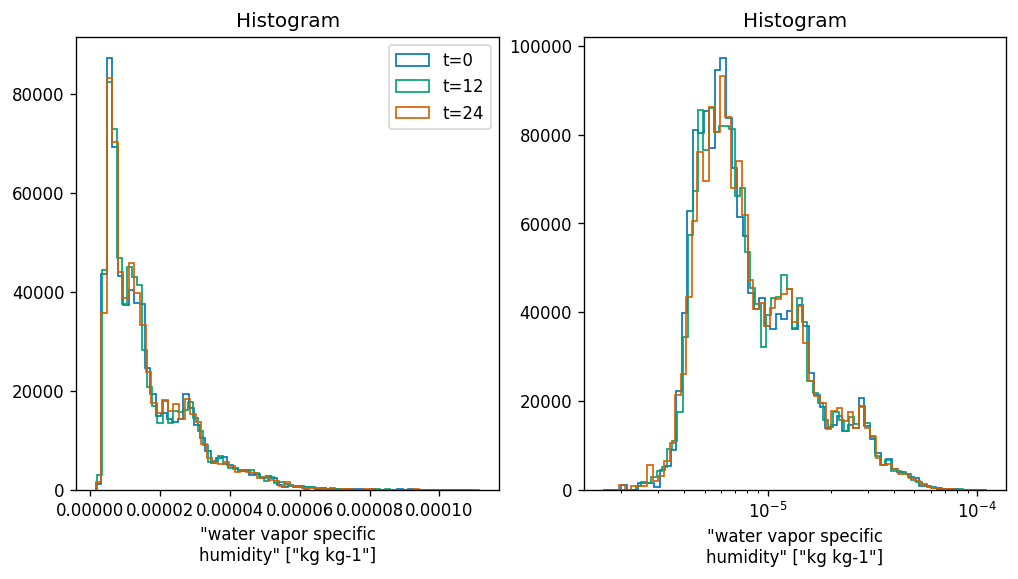

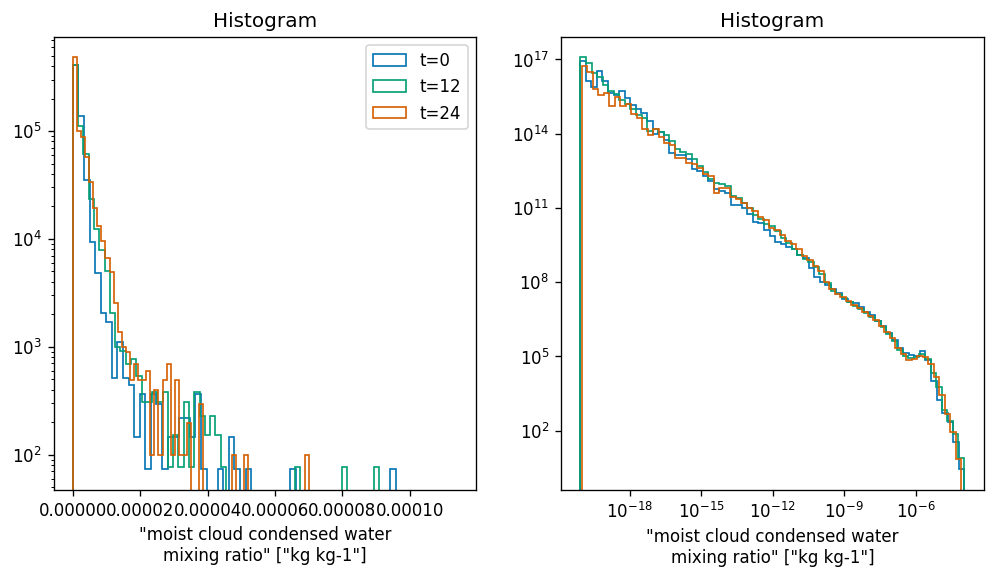

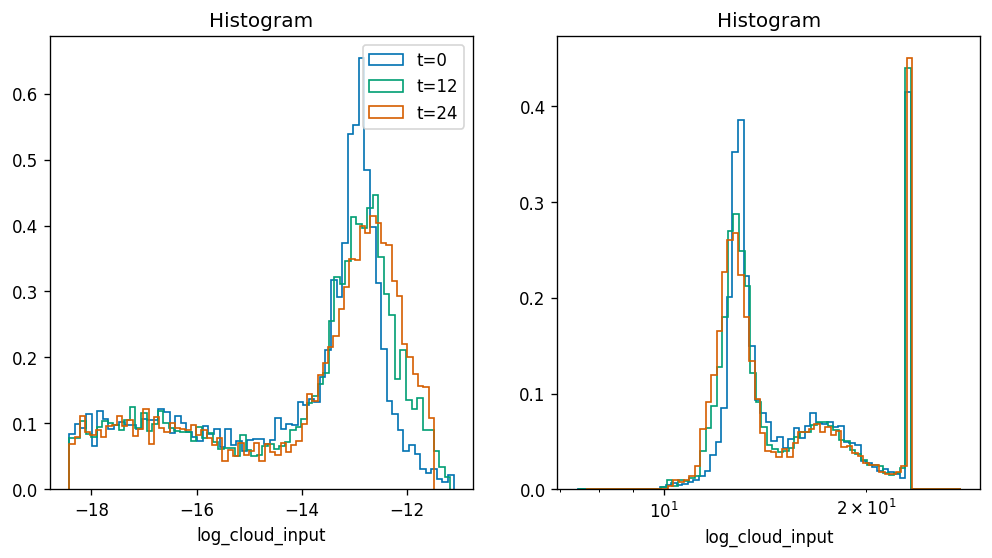

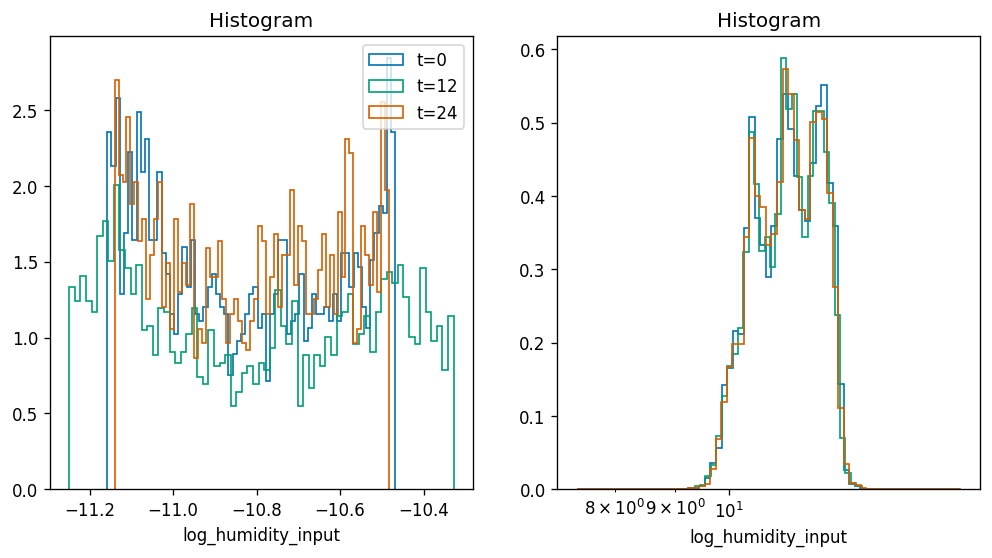

In [91]:
# Use the offline data to set a base distribution
# Plot distributions at T = 0, T = 3 hr, T = 6 hours
# Use a log plot and an absolute magnitued plot


inputs = [
    "air_temperature_input",
    "specific_humidity_input",
    "cloud_water_mixing_ratio_input",
    "log_cloud_input",
    "log_humidity_input",
]

for k in inputs:
    fig, ax = plt.subplots(1,2, dpi=120, figsize=(10, 5))

    for tidx in [0, 1, 2]:
        curr_odata = online_data.isel(time=tidx)[k]
        curr_rh = rh.isel(time=tidx)
        rh_mask = np.logical_and(curr_rh > 0.4, curr_rh < 0.5)
        non_zero_emu_mask = online_data.humidity_gscond_difference != 0.0
        curr_odata = curr_odata.where(rh_mask).where(non_zero_emu_mask)
        lin_bins = sorted(get_bins(curr_odata))
        for_log = abs(curr_odata).where(abs(curr_odata) > 1e-20)
        log_bins = get_bins(for_log, logspace=True)
        
        curr_odata.plot.hist(bins=lin_bins, density=True, ax=ax[0], histtype="step", label=f"t={tidx*12}")
        for_log.plot.hist(bins=log_bins, density=True, ax=ax[1], histtype="step", label=f"t={tidx*12}")

    ax[0].legend()
    ax[1].set_xscale("log")
    if "cloud_water" in k:
        ax[0].set_yscale("log")
        ax[1].set_yscale("log")
    plt.show()
